# Tune linear model with KINOMEscan inhibition profiles

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader


from sklearn import metrics

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset

In [3]:
class Model:
    def __init__(self, name, network):
        self.name = name
        self.network = network
        
    def train(self, train_samples, cell_line_features, drug_features,
             batch_size, optimizer, criterion, reg_lambda=0, log=True):
        """Perform training process by looping over training set in batches (one epoch) of the
        training."""
        no_batches = train_samples.shape[0] // batch_size + 1
        
        # Training the model
        self.network.train()
        for batch in range(no_batches):
            # Separate response variable batch
            if batch != no_batches:
                samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
            else:
                samples_batch = train_samples.iloc[batch * batch_size:]

            # Extract output variable batch
            y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)

            # Extract cell lines IDs for which data shall be extracted
            cl_ids = samples_batch["COSMIC_ID"].values
            # Extract corresponding cell line data
            cell_line_input_batch = cell_line_features.loc[cl_ids].values
            cell_line_input_batch = torch.from_numpy(cell_line_input_batch)

            # Extract drug IDs for which data shall be extracted
            drug_ids = samples_batch["DRUG_ID"].values
            # Extract corresponding drug data
            drug_input_batch = drug_features.loc[drug_ids].values
            drug_input_batch = torch.from_numpy(drug_input_batch)

            # Clear gradient buffers because we don't want to accummulate gradients 
            optimizer.zero_grad()

            # Perform forward pass
            batch_output = self.network(drug_input_batch.float(), cell_line_input_batch.float())

            reg_sum = 0
            for param in self.network.parameters():
                reg_sum += 0.5 * (param ** 2).sum()  # L2 norm

            # Compute the loss for this batch
            loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg_sum
            # Get the gradients w.r.t. the parameters
            loss.backward()
            # Update the parameters
            optimizer.step()
        return loss
    
    def predict(self, samples, cell_line_features, drug_features):
        """Predict response on a given set of samples"""
        y_true = samples["AUC"].values

        cl_input = cell_line_features.loc[samples["COSMIC_ID"].values].values
        drug_input = drug_features.loc[samples["DRUG_ID"].values].values

        self.network.eval()
        with torch.no_grad():
            predicted = self.network(torch.from_numpy(drug_input).float(), 
                             torch.from_numpy(cl_input).float())
        return predicted, y_true
    
    @staticmethod
    def per_drug_performance_df(samples, predicted, mean_training_auc=None):
        """Compute evaluation metrics per drug and return them in a DataFrame"""
        sample_with_predictions = samples.copy()
        sample_with_predictions["Predicted AUC"] = predicted.numpy()

        drugs = []
        model_corrs = []
        model_rmses = []
        dummy_corrs = []
        dummy_rmses = []
        no_samples = []

        for drug in sample_with_predictions.DRUG_ID.unique():
            df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
            if df.shape[0] < 2:
                continue
            if mean_training_auc:
                dummy_preds = [mean_training_auc] * df.shape[0]
            else:
                dummy_preds = [df["AUC"].mean()] * df.shape[0]
            dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
            dummy_corr = pearsonr(df["AUC"], dummy_preds)

            model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
            model_corr = pearsonr(df["AUC"], df["Predicted AUC"])

            drugs.append(drug)
            dummy_rmses.append(dummy_rmse)
            dummy_corrs.append(dummy_corr[0])

            model_rmses.append(model_rmse)
            model_corrs.append(model_corr[0])

            no_samples.append(df.COSMIC_ID.nunique())

        performance_per_drug = pd.DataFrame()
        performance_per_drug["Drug ID"] = drugs
        performance_per_drug["Model RMSE"] = model_rmses
        performance_per_drug["Model correlation"] = model_corrs

        performance_per_drug["Dummy RMSE"] = dummy_rmses
        performance_per_drug["Dummy correlation"] = dummy_corrs
        performance_per_drug["No. samples"] = no_samples

        return performance_per_drug
        
    @staticmethod
    def evaluate_predictions(y_true, preds):
        """Compute RMSE and correlation with true values for model predictions"""
        return metrics.mean_squared_error(y_true, preds) ** 0.5, pearsonr(y_true, preds)

## Load KINOMEscan preprocessed dataset with intersection of proteins screened for drugs

In [4]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


## Data preprocessing

#### Establish response data for samples (drug-cell line pairs)

In [5]:
response_df = full_dataset.response_data.copy()
print(response_df.shape, response_df.COSMIC_ID.nunique())
response_df.head(3)

(55936, 3) 987


DRUG_ID  COSMIC_ID       AUC
2748       29     683665  0.945160
2749       29     684055  0.926046
2750       29     684057  0.934873

#### Establish cell line features data

In [6]:
cell_line_data_df = full_dataset.full_cell_lines_data.copy()
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(922, 225)


cell_line_id  PRKX_exp  TIE1_exp  BMPR2_exp  PKMYT1_exp  \
cell_line_id                                                            
906826              906826  4.787607  3.056350   6.395463    5.550737   
687983              687983  5.001763  3.125097   6.634672    5.399054   
910927              910927  5.459631  2.989998   7.945827    5.541005   

              ABL2_exp  PLK1_exp  ACVR1_exp  MAP3K4_mut  SRPK1_exp  \
cell_line_id                                                         
906826        5.492917  3.853142   4.384087           0   7.410108   
687983        5.113815  4.218736   4.786061           0   7.776150   
910927        4.519127  3.694307   4.414635           0   7.079021   

                        ...             Tissue_lung_SCLC  Tissue_lymphoma  \
cell_line_id            ...                                                 
906826                  ...                            0                0   
687983                  ...                            1                0   
910927                  ...                            0                0   

              Tissue_myeloma  Tissue_nervous_system  Tissue_neuroblastoma  \
cell_line_id                                                                
906826                     0                      0                     0   
687983                     0                      0                     0   
910927                     0                      0                     0   

              Tissue_pancreas  Tissue_skin  Tissue_soft_tissue  \
cell_line_id                                                     
906826                      0            0                   0   
687983                      0            0                   0   
910927                      0            0                   0   

              Tissue_thyroid  Tissue_urogenital_system  
cell_line_id                                            
906826                     0                         0  
687983                     0                         0  
910927                     0                         0  

[3 rows x 225 columns]

In [7]:
# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
print(len(missing_cell_lines))

66


In [8]:
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_df.index = cell_line_data_df.cell_line_id
cell_line_data_df = cell_line_data_df.drop("cell_line_id", axis=1)

In [9]:
# Extract response only for cell lines for which features are present
print(response_df.shape)
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]
print(response_df.shape)

(55936, 3)
(52730, 3)


#### Establish drug features data

In [10]:
drug_data_df = full_dataset.drugs_data.copy()
print(drug_data_df.shape)
# Convert drug index from LINCS name to GDSC drug ID
drug_data_df.index = drug_data_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
drug_data_df.head(3)

(74, 294)


Protein         MAPKAPK2  MARK1  CAMKK2  MARK2  TGFBR1   ERK5  EPHA7   MK01  \
Small Molecule                                                                
1242               100.0   83.0    88.0   96.0    57.0  100.0   92.0   64.0   
86                 100.0  100.0     2.0   13.0   100.0  100.0  100.0  100.0   
29                 100.0  100.0    28.0   92.0   100.0  100.0   84.0  100.0   

Protein          RAF1  TNNI3K  ...     KGP1  ZAP70   ERK3    BLK  MYLK2  \
Small Molecule                 ...                                        
1242            100.0    77.0  ...     99.0   86.0   98.0   57.0   80.0   
86              100.0   100.0  ...      0.7  100.0  100.0  100.0  100.0   
29                2.3    15.0  ...    100.0  100.0  100.0    1.0  100.0   

Protein         KPCD3  FGFR3  ACVR1  GSK3A   KPCD  
Small Molecule                                     
1242             12.0   95.0    1.9  100.0  100.0  
86                1.6  100.0  100.0    1.0    0.9  
29               88.0  100.0  100.0  100.0   89.0  

[3 rows x 294 columns]

In [11]:
# Search for drugs present in response data, but missing the drug features
missing_drugs = []
for drug_id in response_df.DRUG_ID.unique():
    if drug_id not in drug_data_df.index:
        print(drug_id)
        missing_drugs.append(drug_id)
print(len(missing_drugs))

0


#### Split drug response data into training/validation/test 

In [12]:
random_seed = 24
samples_train, samples_val, samples_test, cell_lines_test, cell_lines_val = Dataset.samples_train_test_split(
                                                                            response_df, 100, 100, 
                                                                            random_seed,
                                                                            shuffle=True)
print(response_df.COSMIC_ID.nunique(), samples_train.COSMIC_ID.nunique(), samples_val.COSMIC_ID.nunique(),
     samples_test.COSMIC_ID.nunique())
print(set(samples_train.COSMIC_ID).intersection(set(samples_val.COSMIC_ID)))

921 721 100 100
set()


In [13]:
print(samples_train.AUC.sum(), samples_val.AUC.sum(), samples_test.AUC.sum())

34293.51519 4788.187019999999 4789.471663


#### Normalize / standardize the data

In [14]:
# Cell line data
cols_subset = [col for col in list(cell_line_data_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
print(cell_line_data_df.shape, cell_line_data_df.mean().mean(),
     cell_line_data_df.std().sum())

(922, 224) 0.006113518038248629 194.03164528283756


In [15]:
# Drug data
print(drug_data_df.shape)
drug_data_df = Dataset.standardize_data(drug_data_df)
print(drug_data_df.shape, drug_data_df.mean().mean(),
     drug_data_df.std().sum())

(74, 294)
(74, 294) 2.196104424744604e-17 294.0


## Linear model definition

In [16]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.sum(torch.mul(drug_outputs, cell_line_outputs), dim=1).view(-1, 1)
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs

## Example of training on single set of hyperparameters

In [17]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]
hidden_dim = 10

# Specify network
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, hidden_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)
# Create Model instance
model = Model("Test model instance", network)

# Display text representation of model
model.network

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

In [18]:
# Do the training
# Specify learning parameters
batch_size = 32
learning_rate = 0.01
weight_decay = 0.
reg_lambda = 0.

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.network.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loops
epochs = 50

for epoch in range(epochs):
    loss = model.train(samples_train, cell_line_data_df, drug_data_df, batch_size,
                    optimizer, criterion, reg_lambda=reg_lambda)
    
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.0928
Epoch 2, loss: 0.0238
Epoch 3, loss: 0.0179
Epoch 4, loss: 0.0171
Epoch 5, loss: 0.0167
Epoch 6, loss: 0.0165
Epoch 7, loss: 0.0163
Epoch 8, loss: 0.0162
Epoch 9, loss: 0.0161
Epoch 10, loss: 0.0160
Epoch 11, loss: 0.0159
Epoch 12, loss: 0.0158
Epoch 13, loss: 0.0158
Epoch 14, loss: 0.0157
Epoch 15, loss: 0.0157
Epoch 16, loss: 0.0156
Epoch 17, loss: 0.0156
Epoch 18, loss: 0.0155
Epoch 19, loss: 0.0155
Epoch 20, loss: 0.0154
Epoch 21, loss: 0.0154
Epoch 22, loss: 0.0153
Epoch 23, loss: 0.0153
Epoch 24, loss: 0.0152
Epoch 25, loss: 0.0152
Epoch 26, loss: 0.0151
Epoch 27, loss: 0.0151
Epoch 28, loss: 0.0150
Epoch 29, loss: 0.0150
Epoch 30, loss: 0.0149
Epoch 31, loss: 0.0149
Epoch 32, loss: 0.0149
Epoch 33, loss: 0.0148
Epoch 34, loss: 0.0148
Epoch 35, loss: 0.0147
Epoch 36, loss: 0.0147
Epoch 37, loss: 0.0146
Epoch 38, loss: 0.0146
Epoch 39, loss: 0.0145
Epoch 40, loss: 0.0144
Epoch 41, loss: 0.0144
Epoch 42, loss: 0.0143
Epoch 43, loss: 0.0143
Epoch 44, loss: 0.01

In [19]:
# Evaluate on training data
mean_training_auc = samples_train["AUC"].mean()
baseline_predicted = [mean_training_auc] * samples_train.shape[0] 
predicted, y_true = model.predict(samples_train, cell_line_data_df, drug_data_df)

print("Baseline:", Model.evaluate_predictions(y_true, baseline_predicted))
print("Model:", Model.evaluate_predictions(y_true, predicted.reshape(-1)))

Baseline: (0.1842255757464514, (nan, nan))
Model: (0.10492647437632228, (0.8220437355142464, 0.0))


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [20]:
# Evaluate on validation data
baseline_predicted = [mean_training_auc] * samples_val.shape[0] 
predicted, y_true = model.predict(samples_val, cell_line_data_df, drug_data_df)

print("Baseline:", Model.evaluate_predictions(y_true, baseline_predicted))
print("Model:", Model.evaluate_predictions(y_true, predicted.reshape(-1)))

Baseline: (0.18385496361111775, (nan, nan))
Model: (0.12680619323957487, (0.7319594335751085, 0.0))


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Hyperparameter search for the model

In [18]:
import ray
from ray import tune
from ray.tune import track

In [19]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]

In [20]:
# Specify hyperparameter tuning training loop
def trainable_for_tuning(config):
    # Specify network
    network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, config["hidden_dim"],
                                                 drug_bias=config["drug_bias"],
                                                 cell_line_bias=config["cell_line_bias"],
                                                 out_activation_func=config["out_activation"])
    # Create Model instance
    model = Model("Test Model instance", network)
    
    # Specify loss function
    criterion = config["criterion"]
    # Specify optimizer
    optimizer = torch.optim.SGD(model.network.parameters(), lr=config["lr"])
    
    for epoch in range(1, config["epochs"] + 1):
        # Iterate over traning set
        loss = model.train(samples_train, cell_line_data_df, drug_data_df, config["batch_size"],
                     optimizer, criterion, reg_lambda=config["l2_lambda"])
        # Evaluate on training data
        predicted, y_true = model.predict(samples_train, cell_line_data_df, drug_data_df)
        train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_train, predicted)
        train_median_rmse = performance_df["Model RMSE"].median()
        train_median_corr = performance_df["Model correlation"].median()
        if epoch == config["epochs"]:
            performance_df.to_csv("./performance_per_drug_train.csv", index=False)
        
        # Evaluate on validation data
        predicted, y_true = model.predict(samples_val, cell_line_data_df, drug_data_df)
        val_rmse, val_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_val, predicted)
        val_median_rmse = performance_df["Model RMSE"].median()
        val_median_corr = performance_df["Model correlation"].median()
        if epoch == config["epochs"]:
            performance_df.to_csv("./performance_per_drug_val.csv", index=False)
        
        track.log(loss = loss.item(),
                  train_rmse=train_rmse, 
                  train_corr=train_corr[0], 
                  train_median_rmse = train_median_rmse, 
                  train_median_corr=train_median_corr,
                  val_rmse=val_rmse, 
                  val_corr=val_corr[0], 
                  val_median_rmse = val_median_rmse, 
                  val_median_corr=val_median_corr)
        # print(loss.item())

In [21]:
! ls "./Hyperparameter Tuning Tune Results/"

Test


In [22]:
! rm -r "./Hyperparameter Tuning Tune Results/Test"

In [23]:
! ls "./Hyperparameter Tuning Tune Results/"

In [ ]:
# Specify hyperparameter space to search on
search_space = {
    "lr": tune.loguniform(1e-3, 1e-1),
    "batch_size": tune.choice([16, 32, 64, 128, 256, 512, 1024]),
    "l2_lambda": tune.loguniform(1e-3, 1e-2),
    "hidden_dim": tune.choice([10, 20]),
    "drug_bias": tune.choice(["True"]),
    "cell_line_bias": tune.choice(["True"]),
    "out_activation": tune.choice([torch.sigmoid]),
    "criterion": tune.choice([torch.nn.MSELoss()]),
    "epochs": tune.choice([50, 80])
}

# Resources to request by Tune
ray.shutdown()
ray.init(num_cpus=1, num_gpus=0)

# Run the analysis
results_dir = "./Hyperparameter Tuning Tune Results"
analysis = tune.run(trainable_for_tuning, 
                    name="Test02",
                    config=search_space, num_samples=50, local_dir=results_dir,
                    verbose=1)

2019-12-16 10:11:23,042	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-16 10:11:23,048	INFO resource_spec.py:205 -- Starting Ray with 2.39 GiB memory available for workers and up to 1.2 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-12-16 10:11:23,412	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.5/7.5 GiB



/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:11:58,305	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.489983081817627 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:12:09,387	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4231030941009521 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:12:20,358	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4283461570739746 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:12:31,468	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5651662349700928 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:12:41,883	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.394458532333374 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:12:52,319	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5676369667053223 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:13:02,740	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5599710941314697 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - trainable_for_tuning_1_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.004699,lr=0.05317,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,

2019-12-16 10:13:10,959	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=4971) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=4971)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 10:13:15,199	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5333330631256104 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:13:25,495	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4857611656188965 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:13:35,603	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.3962056636810303 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:13:46,584	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.459073781967163 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:13:56,491	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.3587968349456787 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:14:06,806	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5758945941925049 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:14:17,786	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.582838773727417 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:14:27,891	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.533141851425171 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:14:38,097	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5592575073242188 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 48})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0017517,lr=0.0026467,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:14:48,446	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.067833423614502 seconds to complete, which may be a performance bottleneck.
2019-12-16 10:14:48,494	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=12211) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=12211)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 10:15:02,284	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9340667724609375 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:15:13,398	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8233532905578613 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:15:24,783	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8229126930236816 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:15:36,000	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8491013050079346 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:15:46,970	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.777435541152954 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:15:58,208	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9004411697387695 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:16:09,363	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.836416482925415 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:16:20,590	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9035460948944092 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:16:31,617	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.826500654220581 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:16:42,694	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8379364013671875 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:16:53,884	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8779478073120117 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:17:05,043	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8115565776824951 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:17:16,303	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8313696384429932 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:17:27,611	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8338377475738525 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:17:38,867	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8961195945739746 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:17:50,029	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8510982990264893 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:18:01,151	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8348612785339355 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:18:12,290	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8876266479492188 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:18:23,385	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.770798683166504 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:18:34,557	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8505885601043701 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:18:46,395	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.803471565246582 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:18:57,790	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8447210788726807 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:19:08,981	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.854015588760376 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:19:20,277	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9258718490600586 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:19:31,487	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.865720272064209 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:19:42,544	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8531339168548584 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:19:53,811	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8976643085479736 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:20:04,935	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8184707164764404 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:20:16,181	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7899961471557617 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:20:27,412	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8894011974334717 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:20:38,513	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.782118797302246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:20:49,762	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9511947631835938 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:21:00,906	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7946138381958008 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:21:12,176	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9099698066711426 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:21:23,518	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.868556022644043 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:21:34,673	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7922072410583496 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:21:45,921	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8573219776153564 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:21:56,955	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8303000926971436 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:22:08,185	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.870203971862793 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:22:19,320	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.812969446182251 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:22:30,520	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8851983547210693 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:22:41,671	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8238554000854492 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:22:52,795	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8562777042388916 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:23:04,004	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.88142728805542 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:23:15,121	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7740979194641113 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:23:26,735	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9560558795928955 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:23:37,838	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.797658920288086 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:23:49,078	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9273269176483154 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:24:00,260	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8347599506378174 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:24:10,723	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.0761017799377441 seconds to complete, which may be a performance bottleneck.
2019-12-16 10:24:10,766	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - trainable_for_tuning_3_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0051223,lr=0.053496,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:24:22,264	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5244340896606445 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 46})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:24:33,279	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4084107875823975 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 46})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:24:44,361	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5003235340118408 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 46})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:24:55,351	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.480168342590332 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 46})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:25:06,456	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.55610990524292 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 46})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0071999,lr=0.0010525,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:25:13,643	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.
2019-12-16 10:25:13,972	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff2137ee7301000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=21215) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=21215)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 10:25:22,741	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.464470386505127 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:25:34,943	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4703454971313477 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:25:47,094	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5183517932891846 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:25:59,181	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4942901134490967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:26:11,431	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5659582614898682 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:26:23,384	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4365272521972656 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:26:35,485	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5023906230926514 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:26:47,571	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.487657070159912 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:26:59,667	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4650137424468994 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:27:11,863	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5423376560211182 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:27:23,994	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4405782222747803 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:27:36,198	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5507099628448486 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:27:48,315	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5140931606292725 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:28:00,418	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4979825019836426 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:28:12,508	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4669947624206543 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:28:24,542	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.459172248840332 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:28:36,692	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5387639999389648 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:28:48,816	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5416460037231445 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:29:00,964	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.567786693572998 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:29:12,964	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4506971836090088 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:29:25,232	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.497004747390747 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:29:37,342	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5117943286895752 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:29:49,436	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4654934406280518 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:30:01,592	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5406866073608398 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:30:13,630	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5022637844085693 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:30:25,774	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.551544427871704 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:30:37,836	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4520039558410645 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:30:49,978	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4846727848052979 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:31:02,051	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4581201076507568 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:31:14,038	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4226539134979248 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:31:26,323	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5187199115753174 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:31:38,401	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4691436290740967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:31:50,682	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.564965009689331 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:32:02,673	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4570987224578857 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:32:14,799	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5076003074645996 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:32:26,830	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4611201286315918 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:32:38,955	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.529463291168213 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:32:51,070	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4752042293548584 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:33:03,199	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4814083576202393 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:33:15,371	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.51035475730896 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - trainable_for_tuning_5_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0013414,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:33:20,221	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=6593) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=6593)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 10:33:29,415	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7888729572296143 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:33:41,738	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8687059879302979 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:33:54,131	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8444857597351074 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:34:06,567	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.943464756011963 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:34:18,905	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8107898235321045 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:34:31,188	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.78764009475708 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:34:43,584	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9655990600585938 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:34:55,762	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8138692378997803 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:35:08,166	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8974604606628418 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:35:20,559	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8802058696746826 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:35:32,973	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.907083511352539 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:35:45,155	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8550422191619873 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:35:57,305	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.787147045135498 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:36:09,741	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9334263801574707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:36:21,945	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.803720235824585 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:36:34,337	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9066247940063477 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:36:46,552	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8336067199707031 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:36:58,815	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8586931228637695 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:37:11,091	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8499164581298828 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:37:23,668	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.905418872833252 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:37:35,852	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8013012409210205 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:37:48,069	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8276844024658203 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:38:00,360	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.904822826385498 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:38:12,450	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.758237361907959 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:38:24,854	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9141347408294678 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - trainable_for_tuning_6_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0019196,lr=0.0019172,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 10:38:29,553	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=7049) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=7049)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 10:38:43,323	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8758025169372559 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:38:54,676	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9571545124053955 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:39:05,764	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9065327644348145 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:39:16,803	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8424687385559082 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:39:28,251	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9334256649017334 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:39:39,546	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9491169452667236 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:39:50,674	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.911682367324829 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:40:01,777	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.924917221069336 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:40:12,988	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9550344944000244 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:40:24,203	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8295907974243164 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:40:35,558	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.974189043045044 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:40:46,675	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.858290672302246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:40:57,943	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.921236276626587 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:41:09,260	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9630498886108398 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:41:20,403	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8929221630096436 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:41:31,727	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9290318489074707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:41:42,896	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8751964569091797 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:41:54,071	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9355850219726562 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:42:05,215	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8864760398864746 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:42:16,500	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9330267906188965 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:42:27,564	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.841843843460083 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:42:38,764	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9296109676361084 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:42:49,860	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9558258056640625 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:43:00,934	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.863351583480835 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:43:12,071	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9167163372039795 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:43:23,553	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8465793132781982 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:43:34,764	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.908390998840332 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:43:45,975	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9241068363189697 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:43:57,159	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8967649936676025 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:44:08,497	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9431426525115967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:44:19,567	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.84317946434021 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:44:30,837	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9321370124816895 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:44:41,920	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8437762260437012 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:44:53,171	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.979146957397461 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:45:04,469	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9065043926239014 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:45:15,773	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9584980010986328 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:45:27,197	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8763961791992188 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:45:38,266	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8712010383605957 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:45:49,599	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9672214984893799 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:46:00,801	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9353077411651611 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:46:12,033	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9478585720062256 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:46:23,225	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.885225772857666 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:46:34,375	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9265499114990234 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:46:45,532	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9252266883850098 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:46:56,733	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9341962337493896 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:47:07,870	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8209583759307861 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:47:19,020	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8285906314849854 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:47:30,610	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9294860363006592 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:47:41,749	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8754031658172607 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:47:53,066	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.999279260635376 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:48:04,186	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.884688138961792 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:48:15,459	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9694275856018066 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:48:26,610	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8983447551727295 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:48:37,758	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8886170387268066 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:48:49,085	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.061306953430176 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:49:00,140	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.850870132446289 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:49:12,150	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.921321153640747 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:49:23,657	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8894050121307373 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:49:34,856	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9775421619415283 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:49:46,093	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9023687839508057 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:49:57,264	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.946415662765503 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:50:08,356	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8459606170654297 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:50:19,447	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8285353183746338 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:50:30,758	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9514505863189697 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:50:41,850	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.86151123046875 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:50:52,991	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.920863389968872 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:51:04,282	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9433693885803223 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:51:15,510	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.968400001525879 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:51:26,871	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8659405708312988 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:51:38,133	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9440996646881104 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:51:49,418	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9937100410461426 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:52:00,450	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.879504680633545 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:52:11,817	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9980566501617432 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:52:22,962	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8762118816375732 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:52:34,311	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9649977684020996 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:52:45,327	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8587679862976074 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:52:56,410	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8900325298309326 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:53:07,611	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8540480136871338 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:53:18,667	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8763811588287354 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:53:29,456	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.1657118797302246 seconds to complete, which may be a performance bottleneck.
2019-12-16 10:53:29,506	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - trainable_for_tuning_7_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0075579,lr=0.0041274,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 10:53:39,970	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4145994186401367 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 42})
PENDING trials:
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:53:50,966	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4912912845611572 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 42})
PENDING trials:
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:54:01,756	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4511852264404297 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 42})
PENDING trials:
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:54:12,476	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4883081912994385 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 42})
PENDING trials:
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:54:23,098	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4602775573730469 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 42})
PENDING trials:
 - trainable_for_tuning_8_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0030931,lr=0.090165,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=

2019-12-16 10:54:25,191	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.
2019-12-16 10:54:25,259	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff2bc36e8e01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=12345) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=12345)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_b

2019-12-16 10:54:35,044	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6056811809539795 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:54:46,332	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5544235706329346 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:54:57,543	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.513974905014038 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:55:08,791	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.508063793182373 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:55:19,972	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.527947187423706 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:55:31,570	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5910325050354004 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:55:42,749	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5151257514953613 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:55:54,064	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6187098026275635 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:56:05,357	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5288841724395752 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:56:16,721	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6388165950775146 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:56:27,823	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4775638580322266 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:56:39,154	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5884852409362793 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:56:49,872	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8184459209442139 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:57:01,400	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.667424201965332 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:57:12,359	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6295278072357178 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:57:24,229	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5776360034942627 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - trainable_for_tuning_9_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.002295,lr=0.029765,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:57:35,645	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2252099514007568 seconds to complete, which may be a performance bottleneck.
2019-12-16 10:57:35,694	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=1470) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=1470)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_

2019-12-16 10:57:51,161	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5716328620910645 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:58:03,658	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6506719589233398 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:58:16,133	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6528253555297852 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:58:28,537	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6477172374725342 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:58:41,000	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7146177291870117 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:58:53,886	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5698230266571045 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:59:06,180	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.607945442199707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:59:18,608	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5325682163238525 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:59:31,254	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6056740283966064 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:59:43,547	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5192604064941406 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 10:59:55,975	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6073968410491943 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:00:08,273	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5346572399139404 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:00:20,805	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6593458652496338 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:00:33,136	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5742111206054688 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:00:45,523	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6584398746490479 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:00:57,936	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.589879035949707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:01:10,306	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5535287857055664 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:01:22,952	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6773464679718018 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:01:35,259	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5561158657073975 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:01:47,667	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5993261337280273 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:02:00,098	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.601193904876709 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:02:12,475	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.617692470550537 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:02:24,764	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5652034282684326 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:02:37,223	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6432275772094727 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:02:49,531	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.538515329360962 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:03:01,955	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6707189083099365 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:03:14,111	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6140592098236084 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:03:26,631	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5268924236297607 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:03:39,134	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6400439739227295 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:03:51,437	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.571589469909668 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:04:03,874	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6509978771209717 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:04:16,171	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5417773723602295 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:04:28,629	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6233024597167969 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:04:40,998	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5585637092590332 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:04:53,374	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6075248718261719 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:05:05,671	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5730116367340088 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:05:18,029	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.548907995223999 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:05:30,655	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6465494632720947 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:05:43,014	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5336370468139648 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:05:54,970	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2117116451263428 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:05:55,020	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - trainable_for_tuning_10_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0040732,lr=0.015283,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:05:55,809	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff3d288d9b01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=19108) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=19108)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_

2019-12-16 11:06:06,213	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6062145233154297 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:06:17,687	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6714742183685303 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:06:28,817	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.616161584854126 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:06:40,025	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6494293212890625 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:06:51,254	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6248958110809326 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:07:02,500	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6380889415740967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:07:13,575	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5598475933074951 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:07:25,062	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7030961513519287 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:07:36,169	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6051583290100098 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:07:47,388	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.638293981552124 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:07:58,587	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6455128192901611 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - trainable_for_tuning_11_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0050771,lr=0.0416,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs

2019-12-16 11:08:05,038	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.
2019-12-16 11:08:05,924	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff7990550d01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=13989) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=13989)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 11:08:09,849	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6323466300964355 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:08:21,359	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6960151195526123 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:08:32,746	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.652961254119873 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:08:44,184	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6741931438446045 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:08:55,649	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5755994319915771 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:09:07,154	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.692406177520752 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:09:18,537	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6178035736083984 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - trainable_for_tuning_12_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0027164,lr=0.032798,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:09:29,725	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2122931480407715 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:09:29,776	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=30676) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=30676)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),dru

2019-12-16 11:09:44,966	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6073534488677979 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:09:57,369	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6434516906738281 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:10:09,791	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6746962070465088 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:10:22,108	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6700100898742676 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:10:34,473	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.710550308227539 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:10:46,813	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6556682586669922 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:10:59,262	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6983363628387451 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:11:11,524	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6029882431030273 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:11:24,076	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6639580726623535 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:11:36,400	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6434223651885986 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:11:48,734	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6546249389648438 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:12:00,987	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.622640609741211 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:12:13,410	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.681401252746582 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:12:25,682	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6166326999664307 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:12:37,962	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6491076946258545 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:12:50,287	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6262564659118652 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:13:02,582	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.617708683013916 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:13:15,053	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.704843282699585 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:13:27,484	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5928514003753662 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:13:39,790	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.681011438369751 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:13:52,143	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6225991249084473 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:14:04,444	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7044625282287598 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:14:16,680	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6073966026306152 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:14:29,061	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6195731163024902 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:14:41,298	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6212527751922607 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:14:53,686	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6815943717956543 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:15:06,037	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6365506649017334 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:15:18,255	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6482486724853516 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:15:30,674	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6211907863616943 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:15:43,019	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6304235458374023 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:15:55,419	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.640449047088623 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:16:07,536	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.636415958404541 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:16:19,814	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6938228607177734 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:16:31,962	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.591188669204712 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:16:44,321	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.70686674118042 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:16:56,572	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.626476526260376 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:17:08,628	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.668039083480835 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:17:21,033	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.708509922027588 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:17:33,558	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6934309005737305 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:17:45,174	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.1594088077545166 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:17:45,220	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - trainable_for_tuning_13_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0024522,lr=0.0087535,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:17:58,934	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0079152584075928 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:18:10,034	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.038242816925049 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:18:21,191	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0822882652282715 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:18:32,152	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.978166103363037 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:18:43,256	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.031825304031372 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:18:54,330	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9479408264160156 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:19:06,194	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9417033195495605 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:19:17,351	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.073403835296631 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:19:28,792	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9222958087921143 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:19:39,902	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.059406042098999 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:19:50,855	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.953329086303711 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:20:02,051	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0725810527801514 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:20:13,016	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9425666332244873 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:20:24,127	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0378499031066895 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:20:35,157	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.999680995941162 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:20:46,228	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.047367811203003 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:20:57,216	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9210762977600098 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:21:08,346	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.027496576309204 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:21:19,355	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.969695806503296 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:21:31,067	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0448834896087646 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:21:42,116	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0424485206604004 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:21:53,057	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9622209072113037 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:22:04,168	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.041463613510132 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:22:15,219	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9959251880645752 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:22:26,372	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0909605026245117 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:22:37,409	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0198278427124023 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:22:48,438	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9919662475585938 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:22:59,503	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0073647499084473 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:23:10,562	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9937560558319092 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:23:21,788	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.145179033279419 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:23:33,061	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0416624546051025 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:23:44,059	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9814934730529785 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:23:55,201	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.028310775756836 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:24:06,236	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.982419729232788 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:24:17,244	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9999079704284668 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:24:28,231	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9901845455169678 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:24:39,336	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0177712440490723 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:24:50,366	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.00744891166687 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:25:01,382	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9520387649536133 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:25:12,576	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.058180809020996 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:25:24,069	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.952329158782959 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:25:35,181	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.033374309539795 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:25:46,214	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9744312763214111 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:25:57,439	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.034233331680298 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:26:08,435	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9747982025146484 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:26:19,549	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0506269931793213 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:26:30,511	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9490439891815186 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:26:41,599	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0222814083099365 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:26:52,599	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9634668827056885 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:27:02,868	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2243902683258057 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:27:02,924	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - trainable_for_tuning_14_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0081098,lr=0.048883,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:27:16,542	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5897369384765625 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:27:27,753	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6994895935058594 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:27:38,462	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6321988105773926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:27:49,222	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6457958221435547 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:27:59,910	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.584237813949585 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:28:10,688	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.631922960281372 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:28:21,623	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.671990156173706 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:28:32,412	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.630751609802246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:28:43,268	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6879072189331055 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:28:53,933	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.584562063217163 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:29:04,803	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6808695793151855 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:29:15,499	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5932352542877197 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:29:26,538	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6403255462646484 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:29:37,188	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6270170211791992 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:29:47,928	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6171550750732422 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:29:58,575	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5606105327606201 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:30:04,318	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - trainable_for_tuning_15_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0065951,lr=0.016439,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:30:11,147	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.718461513519287 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:30:21,873	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6334590911865234 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:30:32,703	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7307870388031006 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:30:43,356	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.582728624343872 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:30:54,194	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.644420862197876 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:31:04,909	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5737473964691162 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:31:15,669	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6365911960601807 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:31:26,709	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6269199848175049 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:31:37,545	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.667858600616455 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:31:48,273	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5723669528961182 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:31:59,070	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6360604763031006 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:32:09,935	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6984996795654297 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:32:20,754	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6421236991882324 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:32:31,582	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.678359031677246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:32:42,323	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6076734066009521 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:32:53,241	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6678614616394043 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:33:03,987	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5843820571899414 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - trainable_for_tuning_16_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0024745,lr=0.0061541,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:33:06,217	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.
2019-12-16 11:33:07,035	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff4cefc00001000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=19719) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=19719)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),dr

2019-12-16 11:33:14,465	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.668004035949707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:33:25,024	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5929853916168213 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:33:35,364	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6841797828674316 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:33:45,673	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6641671657562256 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:33:55,936	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6367931365966797 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:34:06,097	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.640427827835083 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:34:16,233	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6500177383422852 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:34:26,413	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6524765491485596 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:34:36,568	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.650937795639038 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:34:46,677	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6174671649932861 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 33})
PENDING trials:
 - trainable_for_tuning_17_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010401,lr=0.0065932,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:34:50,369	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=1033) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=1033)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),dru

2019-12-16 11:34:56,973	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7999825477600098 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:35:08,361	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7153518199920654 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:35:19,796	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7519700527191162 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:35:29,889	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6722843647003174 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:35:41,387	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7990703582763672 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:35:52,874	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6733503341674805 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:36:04,392	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7455871105194092 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - trainable_for_tuning_18_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0017168,lr=0.0094156,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:36:15,334	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2188498973846436 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:36:15,378	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=18282) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=18282)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug

2019-12-16 11:36:29,409	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.698376178741455 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:36:40,313	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6733925342559814 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:36:51,349	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7917909622192383 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:37:02,267	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6510062217712402 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:37:13,298	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7414851188659668 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:37:24,570	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.749453067779541 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:37:35,309	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6350064277648926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:37:46,275	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7732326984405518 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:37:57,094	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6856825351715088 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:38:08,060	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7382252216339111 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:38:18,888	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6401581764221191 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:38:29,827	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.733499526977539 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:38:40,570	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6180627346038818 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:38:51,503	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.701888084411621 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:39:02,236	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6309890747070312 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:39:13,172	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.732081413269043 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:39:24,204	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6778538227081299 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:39:35,087	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6777000427246094 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:39:45,850	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5950427055358887 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:39:56,780	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7520997524261475 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:40:07,556	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6599969863891602 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:40:18,390	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.692579746246338 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:40:29,148	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6224086284637451 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:40:40,090	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7346909046173096 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:40:50,903	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6551270484924316 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:41:01,852	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7572455406188965 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:41:07,538	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 2.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - trainable_for_tuning_19_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0049646,lr=0.0866,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:41:11,818	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5853495597839355 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:41:22,332	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7249987125396729 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:41:32,469	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5967473983764648 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:41:42,615	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6355998516082764 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:41:52,629	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.5599360466003418 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:42:02,703	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6221988201141357 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - trainable_for_tuning_20_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0021898,lr=0.0054977,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 11:42:05,940	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=31872) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=31872)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),d

2019-12-16 11:42:16,230	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7223553657531738 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:42:27,224	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.82063627243042 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:42:38,006	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6877188682556152 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:42:48,831	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7561936378479004 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:42:59,599	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7205941677093506 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:43:10,494	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.734412670135498 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:43:21,434	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9296948909759521 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:43:32,412	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8142273426055908 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:43:43,035	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7194812297821045 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:43:53,938	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8204805850982666 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:44:04,645	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6858599185943604 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:44:15,550	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7687153816223145 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:44:26,293	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.676849603652954 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:44:37,289	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8259656429290771 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:44:48,061	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6558470726013184 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:44:58,947	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7498779296875 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - trainable_for_tuning_21_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0010429,lr=0.070144,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,

2019-12-16 11:45:09,440	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2731249332427979 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:45:09,480	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=1071) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=1071)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),dru

2019-12-16 11:45:20,652	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9081203937530518 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:45:30,959	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6066980361938477 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:45:41,192	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6777384281158447 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:45:51,447	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6183195114135742 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:46:01,560	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.644421100616455 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:46:11,781	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6849751472473145 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:46:22,167	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6892826557159424 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:46:32,474	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6500887870788574 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - trainable_for_tuning_22_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0031446,lr=0.0014117,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 11:46:42,772	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.6521871089935303 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:46:42,826	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=8903) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=8903)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_

2019-12-16 11:46:53,964	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.14925479888916 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:47:04,796	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.392446756362915 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:47:15,301	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8223743438720703 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:47:27,227	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.0904879570007324 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:47:36,899	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8937046527862549 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.4/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:47:48,005	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9564247131347656 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:47:58,479	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2702314853668213 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:48:09,377	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.413754940032959 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:48:20,261	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.590163230895996 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:48:30,463	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.6432836055755615 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:48:40,816	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.9840662479400635 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:48:50,759	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9312288761138916 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:49:02,884	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.6398909091949463 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:49:09,390	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - trainable_for_tuning_23_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0050717,lr=0.014945,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 11:49:16,492	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.487760066986084 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:49:26,878	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8531510829925537 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:49:37,847	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.634366750717163 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:49:49,087	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.263625144958496 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:50:00,007	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.191054344177246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:50:10,982	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0314271450042725 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:50:20,967	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9669854640960693 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:50:32,072	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1409592628479004 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:50:43,293	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1147594451904297 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:50:54,395	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1795718669891357 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:51:05,085	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.332871198654175 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.4/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:51:15,969	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.367617130279541 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.4/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:51:26,779	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9508497714996338 seconds to complete, which may be a performance bottleneck.
2019-12-16 11:51:28,316	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 23, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - trainable_for_tuning_24_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0010302,lr=0.013797,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:51:44,392	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.7029919624328613 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:51:57,923	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.7184178829193115 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:52:11,265	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.277682304382324 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:52:24,198	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.645397424697876 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:52:38,720	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5866968631744385 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:52:56,044	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.545647621154785 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:53:14,796	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.527036428451538 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.4/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:53:30,397	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.40533709526062 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:53:42,526	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2053511142730713 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:53:54,453	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.112227201461792 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:54:06,041	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2951905727386475 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:54:18,307	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2340760231018066 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:54:31,602	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.479996919631958 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:54:44,022	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.451383113861084 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:54:57,196	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4683077335357666 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:55:11,850	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.463747262954712 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:55:24,772	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.269505262374878 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:55:37,170	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2224202156066895 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:55:49,126	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.258654832839966 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:56:00,638	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2047717571258545 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:56:12,688	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2255125045776367 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:56:24,126	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.159403085708618 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:56:35,616	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2387149333953857 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:56:47,032	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1692616939544678 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:56:58,792	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.291079044342041 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:57:10,156	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.229461193084717 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:57:22,133	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.542860507965088 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:57:34,790	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.385057210922241 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:57:50,502	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.279304027557373 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:58:01,838	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1846187114715576 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:58:13,345	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.255825996398926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:58:24,678	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1687276363372803 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:58:36,156	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1825194358825684 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:58:47,496	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.184295177459717 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:58:59,271	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.23886775970459 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:59:10,742	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.227611780166626 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:59:22,326	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4132323265075684 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:59:33,988	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2707107067108154 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:59:45,325	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1585566997528076 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 11:59:56,800	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2917821407318115 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:00:08,131	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1849253177642822 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:00:19,591	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2839932441711426 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:00:30,818	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.155282735824585 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:00:42,247	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2372632026672363 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:00:53,575	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.190260648727417 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:01:05,029	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.266540765762329 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:01:16,293	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.118255138397217 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:01:28,452	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2479665279388428 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:01:39,703	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1371982097625732 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:01:50,360	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.3687398433685303 seconds to complete, which may be a performance bottleneck.
2019-12-16 12:01:50,415	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - trainable_for_tuning_25_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0011144,lr=0.011587,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoch

2019-12-16 12:02:04,665	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.213526725769043 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:02:16,292	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.339064598083496 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:02:27,732	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2092700004577637 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:02:39,508	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.430821418762207 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:02:50,941	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2042977809906006 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:03:02,684	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.342264413833618 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:03:13,976	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.118818521499634 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:03:26,449	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2825350761413574 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:03:37,874	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2008442878723145 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:03:49,479	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3566975593566895 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:04:00,996	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.262490749359131 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:04:12,511	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2763893604278564 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:04:23,880	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.168884754180908 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:04:35,382	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.234137773513794 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:04:46,851	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.266510009765625 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:04:58,305	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.210871458053589 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:05:09,797	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2389116287231445 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:05:21,427	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.389739990234375 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:05:33,219	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.24200177192688 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:05:44,780	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2042734622955322 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:05:56,369	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3339390754699707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:06:07,681	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.199436902999878 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:06:19,242	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3297464847564697 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:06:30,587	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.181488275527954 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:06:42,145	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.313124418258667 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:06:53,542	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.182981491088867 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:07:05,076	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2849855422973633 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:07:16,488	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.196455955505371 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:07:28,823	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2298150062561035 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:07:40,366	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3008229732513428 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:07:51,923	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3096694946289062 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:08:03,353	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2009265422821045 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:08:14,898	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2748801708221436 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:08:26,292	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2209649085998535 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:08:37,955	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.399010419845581 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:08:49,319	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2164978981018066 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:09:00,838	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2927112579345703 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:09:12,201	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1520192623138428 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:09:24,664	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3638193607330322 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:09:36,030	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.189896821975708 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:09:47,580	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3331751823425293 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:09:59,058	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3099775314331055 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:10:10,385	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1691298484802246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:10:21,938	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2941184043884277 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:10:33,237	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1898891925811768 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:10:44,811	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2928030490875244 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:10:56,200	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.23852801322937 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:11:07,697	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.264064311981201 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:11:19,108	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2473387718200684 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:11:31,352	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.249843120574951 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:11:42,783	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.254549741744995 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:11:54,240	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2977325916290283 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:12:05,671	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.153888463973999 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:12:17,177	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2862162590026855 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:12:28,551	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.219423770904541 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:12:40,085	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2865922451019287 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:12:51,532	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.197566509246826 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:13:03,088	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2878427505493164 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:13:14,474	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2296581268310547 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:13:26,814	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3261144161224365 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:13:38,208	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.228614568710327 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:13:49,748	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.342697858810425 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:14:01,099	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1770150661468506 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:14:12,593	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2790894508361816 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:14:24,033	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.22927188873291 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:14:35,546	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2751588821411133 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:14:46,931	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1934306621551514 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:14:58,458	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2673559188842773 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:15:09,891	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.248591661453247 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:15:21,662	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5369338989257812 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:15:33,395	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.322256326675415 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:15:44,700	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.162753105163574 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:15:56,264	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.280750036239624 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:16:07,643	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1669294834136963 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:16:19,113	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2567298412323 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:16:30,530	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2165050506591797 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:16:42,170	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.2848782539367676 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:16:53,476	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.119690418243408 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:17:05,070	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3080852031707764 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:17:15,547	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.2808024883270264 seconds to complete, which may be a performance bottleneck.
2019-12-16 12:17:15,599	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - trainable_for_tuning_26_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0079006,lr=0.014126,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:17:26,282	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7788724899291992 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:17:37,110	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.750199317932129 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:17:48,112	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8796563148498535 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:17:58,889	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7741694450378418 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:18:09,818	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7922301292419434 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:18:20,606	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7378544807434082 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:18:31,482	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8174018859863281 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:18:42,405	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7912178039550781 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:18:53,333	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8363533020019531 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:19:04,087	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7470130920410156 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:19:15,179	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9508881568908691 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:19:26,400	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7305519580841064 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:19:37,345	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8128762245178223 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:19:48,167	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8175108432769775 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:19:59,025	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7630438804626465 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:20:09,997	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.894087314605713 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 26, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - trainable_for_tuning_27_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013486,lr=0.012828,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:20:20,354	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.3060853481292725 seconds to complete, which may be a performance bottleneck.
2019-12-16 12:20:20,397	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=8244) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=8244)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug

2019-12-16 12:20:34,277	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8310513496398926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:20:45,003	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7829382419586182 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:20:55,787	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.839545488357544 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:21:06,604	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.781834602355957 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:21:17,381	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8040485382080078 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:21:28,508	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7932512760162354 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:21:41,036	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3383290767669678 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:21:54,417	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7306928634643555 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:22:05,596	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0527684688568115 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:22:17,899	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3291139602661133 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:22:30,342	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.569183349609375 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:22:39,951	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8670923709869385 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:22:51,640	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8983781337738037 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:23:03,072	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.889591932296753 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:23:14,629	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.896869421005249 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:23:26,493	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9157776832580566 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:23:37,990	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8734767436981201 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - trainable_for_tuning_28_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0053346,lr=0.0022646,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:23:40,311	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=10261) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=10261)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug

2019-12-16 12:23:48,994	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0111567974090576 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:23:59,363	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8940131664276123 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:24:09,898	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9782531261444092 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:24:20,218	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.851590871810913 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:24:30,609	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8710124492645264 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:24:40,872	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8494062423706055 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:24:51,245	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.92836594581604 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:25:01,883	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9627315998077393 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:25:12,605	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8959054946899414 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:25:23,544	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.023559093475342 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:25:34,286	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0646491050720215 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:25:44,748	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9254424571990967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:25:55,387	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1608731746673584 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - trainable_for_tuning_29_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0080717,lr=0.094666,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:26:02,384	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=5308) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=5308)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 12:26:09,858	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.889721393585205 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:26:21,841	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0751795768737793 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:26:33,890	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.949963092803955 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:26:45,746	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8616929054260254 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:26:57,547	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.976233959197998 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:27:09,187	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.929548740386963 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:27:21,500	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1728923320770264 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:27:33,616	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8718173503875732 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:27:45,572	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.139328718185425 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.5/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:27:57,312	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8789403438568115 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:28:09,302	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9744713306427002 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:28:21,035	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9986674785614014 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:28:34,590	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3993711471557617 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:28:49,129	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0795364379882812 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:29:00,776	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9427025318145752 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:29:12,326	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.944955587387085 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:29:24,284	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8691883087158203 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - trainable_for_tuning_30_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0037189,lr=0.0036992,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:29:26,541	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=7329) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=7329)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_

2019-12-16 12:29:37,690	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9868066310882568 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:29:49,148	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9070477485656738 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:30:00,817	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9435553550720215 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:30:12,345	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8706464767456055 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:30:24,025	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9510736465454102 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:30:35,661	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8957805633544922 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:30:47,298	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9695565700531006 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:30:58,795	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.884509563446045 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:31:10,364	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9198534488677979 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:31:22,257	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.280148506164551 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:31:33,984	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.874413013458252 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:31:45,574	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.958625316619873 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:31:57,083	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9223408699035645 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:32:08,676	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9457764625549316 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:32:20,208	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9074649810791016 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:32:31,885	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9985435009002686 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:32:43,400	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9058587551116943 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:32:55,068	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9519238471984863 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:33:06,609	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9048593044281006 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:33:18,185	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9187812805175781 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:33:30,085	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8931748867034912 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:33:41,765	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9831020832061768 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:33:53,404	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9972589015960693 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:34:05,519	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0187342166900635 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:34:17,259	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.913276195526123 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:34:28,813	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8832333087921143 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:34:40,016	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4858059883117676 seconds to complete, which may be a performance bottleneck.
2019-12-16 12:34:40,058	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - trainable_for_tuning_31_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0014979,lr=0.015241,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:34:40,685	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff86e8d3fc01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=16868) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=16868)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),dru

2019-12-16 12:34:51,540	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8553128242492676 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:35:02,527	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8787858486175537 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:35:13,500	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8395509719848633 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:35:24,954	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9471299648284912 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:35:35,919	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8240666389465332 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:35:46,922	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8647034168243408 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:35:57,841	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8037495613098145 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:36:08,902	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9180312156677246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:36:19,949	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8929834365844727 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:36:30,915	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8318862915039062 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 31, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - trainable_for_tuning_32_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0036253,lr=0.0051724,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:36:32,269	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=30633) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=30633)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 12:36:42,341	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9923443794250488 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:36:55,630	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.946587324142456 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:37:09,019	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0112593173980713 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:37:22,835	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.200277090072632 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:37:36,393	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.043757200241089 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:37:49,719	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8961091041564941 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:38:03,293	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.024829387664795 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:38:16,721	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.069293737411499 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:38:30,027	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0148582458496094 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:38:43,381	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9982874393463135 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:38:56,646	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.939375638961792 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:39:09,975	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9903080463409424 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:39:23,589	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.975428819656372 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:39:37,766	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1318769454956055 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:39:51,640	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0521302223205566 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:40:05,461	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.033123254776001 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:40:19,326	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0385708808898926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:40:33,194	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.02880859375 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:40:47,111	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.068779706954956 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:41:00,893	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9770891666412354 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:41:14,809	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.049898386001587 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:41:29,074	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.960843801498413 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:41:43,037	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0960817337036133 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:41:56,817	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9876563549041748 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:42:10,801	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0769879817962646 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:42:24,556	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.010364532470703 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:42:38,370	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.043344736099243 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:42:52,167	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.025209665298462 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:43:06,247	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.103189706802368 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:43:19,986	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0493438243865967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:43:34,380	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.056035041809082 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:43:48,434	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1084673404693604 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:44:02,339	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9612948894500732 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:44:16,333	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0913009643554688 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:44:30,108	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9985682964324951 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:44:44,192	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0375654697418213 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:44:58,002	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9680931568145752 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:45:12,279	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0988900661468506 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:45:26,555	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9698638916015625 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:45:40,660	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0841565132141113 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:45:45,801	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - trainable_for_tuning_33_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0016771,lr=0.08911,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:46:01,892	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5092990398406982 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:46:14,841	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5137481689453125 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:46:27,935	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5902514457702637 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:46:40,851	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4326605796813965 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:46:54,113	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5360734462738037 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:47:07,127	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5056161880493164 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:47:20,201	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.558274030685425 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:47:34,163	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.424361228942871 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:47:47,192	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.497628927230835 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:48:00,353	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5385892391204834 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:48:13,257	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4299097061157227 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:48:26,591	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.523815155029297 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:48:39,527	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4386422634124756 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:48:52,552	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.463188648223877 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:49:04,897	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.444643020629883 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:49:17,658	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.468505859375 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:49:31,683	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5163204669952393 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:49:48,346	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.820906162261963 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:50:07,508	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.889699697494507 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:50:22,037	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.448554515838623 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:50:35,189	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5054595470428467 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:50:48,309	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4394564628601074 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:51:01,358	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5654172897338867 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:51:14,209	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4609248638153076 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:51:28,305	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.529756546020508 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:51:41,161	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4854588508605957 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:51:54,312	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5915520191192627 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:52:07,246	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4611566066741943 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:52:20,159	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4480936527252197 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:52:33,169	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.51271390914917 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:52:46,165	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4519283771514893 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:52:59,131	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.560767650604248 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:53:11,790	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.453355550765991 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:53:25,941	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5496110916137695 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:53:46,809	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4306647777557373 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:54:02,171	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.535996198654175 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:54:15,963	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.431771755218506 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:54:29,560	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5296528339385986 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:54:43,510	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.595090627670288 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:55:00,556	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.525686502456665 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:55:13,119	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.6736466884613037 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:55:26,441	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3359203338623047 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:55:41,312	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4536895751953125 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:55:52,934	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3072116374969482 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:56:04,942	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3766140937805176 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:56:16,638	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.469581127166748 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:56:28,926	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3688313961029053 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:56:41,169	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.423614025115967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:56:53,359	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5145230293273926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:57:04,415	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.4877426624298096 seconds to complete, which may be a performance bottleneck.
2019-12-16 12:57:04,457	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - trainable_for_tuning_34_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0013505,lr=0.094468,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:57:15,665	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.868633508682251 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 15})
PENDING trials:
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:57:26,675	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8748741149902344 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 15})
PENDING trials:
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:57:37,248	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8179216384887695 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 15})
PENDING trials:
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:57:47,940	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8856861591339111 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 15})
PENDING trials:
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:57:58,521	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7789535522460938 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 15})
PENDING trials:
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:58:09,209	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8891139030456543 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 15})
PENDING trials:
 - trainable_for_tuning_35_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0047407,lr=0.058788,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 12:58:13,041	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=26270) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=26270)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),dru

2019-12-16 12:58:21,065	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9296841621398926 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:58:32,587	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.856396198272705 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:58:45,400	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.135721206665039 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:58:55,618	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0651726722717285 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:59:07,782	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9509246349334717 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:59:19,732	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0127227306365967 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:59:29,854	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0040504932403564 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:59:41,807	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8942289352416992 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 12:59:53,812	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.027289867401123 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:00:05,996	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9545953273773193 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:00:17,878	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8638699054718018 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:00:30,067	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.992675542831421 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:00:42,262	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9011485576629639 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:00:54,320	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.023085355758667 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:01:05,826	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.548349380493164 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.6/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:01:16,380	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.899266242980957 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:01:26,545	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.053299903869629 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:01:32,229	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - trainable_for_tuning_36_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=20,l2_lambda=0.0020121,lr=0.021481,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epoc

2019-12-16 13:01:32,687	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff11dff3e501000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 2.392578 GiB}, {object_store_memory: 0.830078 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=15499) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=15499)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 13:01:39,887	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9969935417175293 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:01:51,262	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0976850986480713 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:02:04,016	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1352767944335938 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:02:16,597	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0748794078826904 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:02:28,626	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.3440892696380615 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:02:40,968	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1021764278411865 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:02:53,777	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0861382484436035 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:03:07,404	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.0176424980163574 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:03:20,471	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.7260513305664062 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:03:31,240	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.015695095062256 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:03:46,136	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.0161683559417725 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:03:55,421	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0679550170898438 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:04:09,438	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.6080033779144287 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:04:19,656	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.442652463912964 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:04:31,337	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0139760971069336 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:04:44,831	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4483606815338135 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:04:58,759	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.4160780906677246 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:05:09,344	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.673471450805664 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.8/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:05:21,906	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9972436428070068 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:05:34,087	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.051358461380005 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:05:45,140	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.8585405349731445 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:05:56,378	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0186357498168945 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:06:08,737	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1379714012145996 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:06:20,793	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0907440185546875 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:06:33,586	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.365205764770508 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:06:46,084	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.200498342514038 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:06:57,752	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9513866901397705 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:07:09,034	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0497043132781982 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:07:21,350	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.962493896484375 seconds to complete, which may be a performance bottleneck.
2019-12-16 13:07:21,399	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - trainable_for_tuning_37_batch_size=512,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=80,hidden_dim=10,l2_lambda=0.0025087,lr=0.024431,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epo

2019-12-16 13:07:32,332	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9332129955291748 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:07:42,501	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.09237003326416 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:07:53,203	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9630250930786133 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:08:04,245	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0089008808135986 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:08:15,759	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.1909046173095703 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:08:26,198	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.7945728302001953 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:08:37,621	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.027275800704956 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:08:47,928	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.0382320880889893 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:08:58,390	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.01763653755188 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:09:09,547	WARNING util.py:133 -- The `experiment_checkpoint` operation took 1.9525725841522217 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - trainable_for_tuning_38_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0011519,lr=0.0018865,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:09:16,265	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=7092) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=7092)   warnings.warn(PearsonRConstantInputWarning())


2019-12-16 13:09:26,836	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.6906445026397705 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:09:44,188	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.140516757965088 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:10:02,549	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.2261056900024414 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:10:21,321	WARNING util.py:133 -- The `experiment_checkpoint` operation took 3.246633529663086 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:10:31,203	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.715454339981079 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:10:49,006	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.6168644428253174 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:11:07,457	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.5861988067626953 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

2019-12-16 13:11:20,781	WARNING util.py:133 -- The `experiment_checkpoint` operation took 2.532825231552124 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/2.39 GiB heap, 0.0/0.83 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test
Number of trials: 50 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - trainable_for_tuning_39_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=20,l2_lambda=0.0051998,lr=0.0031919,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_40_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=50,hidden_dim=10,l2_lambda=0.0046035,lr=0.0024273,out_activation=<built-in method sigmoid of type object at 0x7fb258d17fc0>:	PENDING
 - trainable_for_tuning_41_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,e

In [29]:
full_df = analysis.dataframe()
full_df.to_csv(analysis._experiment_dir + "/" + "analysis_results.csv", index=False)
print(full_df.shape)
metrics = ["train_rmse", "train_corr", "train_median_rmse", "train_median_corr",
          "val_rmse", "val_corr"]
cols = ["pid"] + [x for x in full_df if x.startswith("config")] + ["training_iteration"]

full_df[cols + metrics]

(3, 35)


pid  config/batch_size config/cell_line_bias config/criterion  \
0   2803                 32                  True        MSELoss()   
1   2934                 32                  True        MSELoss()   
2  28930                256                  True        MSELoss()   

  config/drug_bias  config/epochs  config/hidden_dim  config/l2_lambda  \
0             True             10                 10          0.007292   
1             True             10                 20          0.003636   
2             True             10                 10          0.007429   

   config/lr                              config/out_activation  \
0   0.001850  <built-in method sigmoid of type object at 0x7...   
1   0.022081  <built-in method sigmoid of type object at 0x7...   
2   0.005076  <built-in method sigmoid of type object at 0x7...   

   training_iteration  train_rmse  train_corr  train_median_rmse  \
0                   9    0.153878    0.668105           0.150043   
1                   9    0.111276    0.805406           0.099233   
2                   9    0.358978    0.204046           0.358114   

   train_median_corr  val_rmse  val_corr  
0           0.209634  0.163420  0.621323  
1           0.486353  0.124467  0.744520  
2           0.062152  0.363249  0.196982

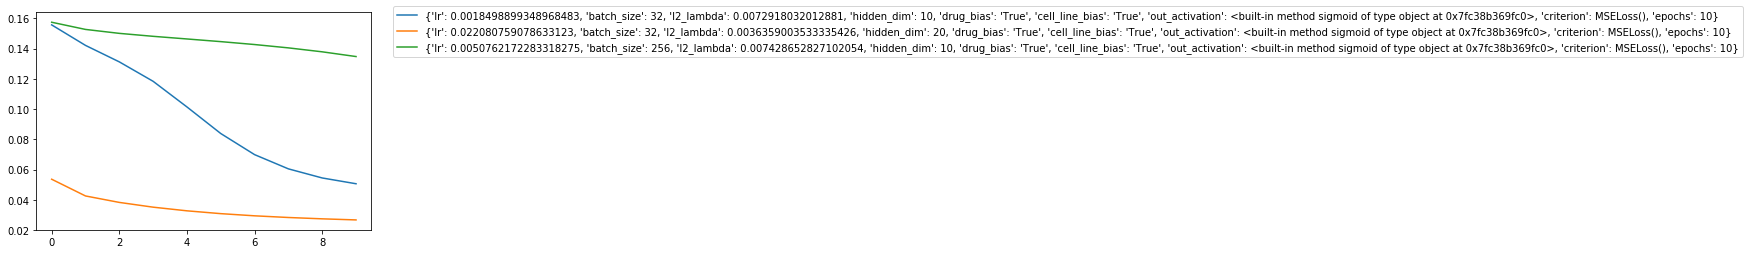

In [30]:
metric = "loss"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    plt.plot(df["training_iteration"], df[metric], label=str(trial.config))

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

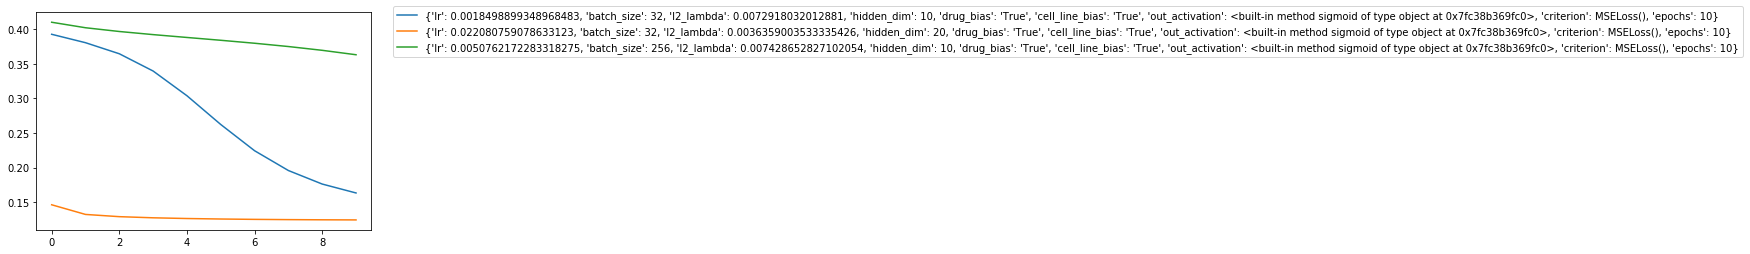

In [33]:
metric = "val_rmse"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    plt.plot(df["training_iteration"], df[metric], label=str(trial.config))

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

In [45]:
best_parameters = analysis.get_best_config(metric="val_rmse", mode="min")
print(best_parameters)

{'batch_size': 32, 'cell_line_bias': 'True', 'criterion': 'MSELoss()', 'drug_bias': 'True', 'epochs': 10, 'hidden_dim': 20, 'l2_lambda': 0.0036359003533335426, 'lr': 0.022080759078633123, 'out_activation': '<built-in method sigmoid of type object at 0x7fc38b369fc0>'}


In [47]:
type(best_parameters["out_activation"])

str

## Results analysis

## Hyperparameter tuning and validation on the test set

In [21]:
import ray
from ray import tune
from ray.tune import track

In [22]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]

In [23]:
# Specify hyperparameter tuning training loop
def trainable_for_tuning(config):
    # Specify network
    network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, config["hidden_dim"],
                                                 drug_bias=config["drug_bias"],
                                                 cell_line_bias=config["cell_line_bias"],
                                                 out_activation_func=config["out_activation"])
    # Create Model instance
    model = Model("Test Model instance", network)
    
    # Specify loss function
    criterion = config["criterion"]
    # Specify optimizer
    optimizer = torch.optim.SGD(model.network.parameters(), lr=config["lr"])
    
    for epoch in range(1, config["epochs"] + 1):
        # Iterate over traning set
        loss = model.train(samples_train, cell_line_data_df, drug_data_df, config["batch_size"],
                     optimizer, criterion, reg_lambda=config["l2_lambda"])
        # Evaluate on training data
        predicted, y_true = model.predict(samples_train, cell_line_data_df, drug_data_df)
        train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_train, predicted)
        train_median_rmse = performance_df["Model RMSE"].median()
        train_median_corr = performance_df["Model correlation"].median()
        
        # Evaluate on validation data
        predicted, y_true = model.predict(samples_val, cell_line_data_df, drug_data_df)
        val_rmse, val_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_val, predicted)
        val_median_rmse = performance_df["Model RMSE"].median()
        val_median_corr = performance_df["Model correlation"].median()
        
        track.log(loss = loss.item(),
                  train_rmse=train_rmse, 
                  train_corr=train_corr[0], 
                  train_median_rmse = train_median_rmse, 
                  train_median_corr=train_median_corr,
                  val_rmse=val_rmse, 
                  val_corr=val_corr[0], 
                  val_median_rmse = val_median_rmse, 
                  val_median_corr=val_median_corr)
        # print(loss.item())

In [20]:
! ls "./Hyperparameter Tuning Tune Results/"

Test


In [59]:
! rm -r "./Hyperparameter Tuning Tune Results/"

In [60]:
! ls "./Hyperparameter Tuning Tune Results/"

ls: nie ma dostępu do './Hyperparameter Tuning Tune Results/': Nie ma takiego pliku ani katalogu


In [26]:
# Specify hyperparameter space to search on
search_space = {
    "lr": tune.loguniform(1e-3, 1e-1),
    "batch_size": tune.choice([16, 32, 64, 128, 256, 512, 1024]),
    "l2_lambda": tune.choice([0.0, 1e-4, 1e-2]),
    "hidden_dim": tune.choice([10, 20]),
    "drug_bias": tune.choice(["True"]),
    "cell_line_bias": tune.choice(["True"]),
    "out_activation": tune.choice([torch.sigmoid]),
    "criterion": tune.choice([torch.nn.MSELoss()]),
    "epochs": tune.choice([20, 30])
}

# Resources to request by Tune
ray.shutdown()
ray.init(num_cpus=1, num_gpus=0)

# Run the analysis
results_dir = "./Hyperparameter Tuning Tune Results"
experiment_name = "Test02"
analysis = tune.run(trainable_for_tuning, 
                    name=experiment_name,
                    config=search_space, num_samples=10, local_dir=results_dir,
                    verbose=1)

2019-12-16 13:16:42,670	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-16 13:16:42,673	INFO resource_spec.py:205 -- Starting Ray with 0.73 GiB memory available for workers and up to 0.38 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-12-16 13:16:43,020	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.7/7.5 GiB



/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/krzysztof/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - trainable_for_tuning_1_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.0,lr=0.019025,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.068157,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - trainable_for_tuning_1_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.0,lr=0.019025,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.068157,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - trainable_for_tuning_1_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.0,lr=0.019025,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.068157,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - trainable_for_tuning_1_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.0,lr=0.019025,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.068157,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=

2019-12-16 13:17:56,717	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - trainable_for_tuning_1_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.0,lr=0.019025,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.068157,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 8})
PENDING trials:
 - trainable_for_tuning_2_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.068157,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_

2019-12-16 13:18:30,592	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=1725) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=1725)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=Tr

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

2019-12-16 13:22:00,372	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5290102958679199 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

2019-12-16 13:22:12,354	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - trainable_for_tuning_3_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0,lr=0.0025032,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden

2019-12-16 13:22:13,306	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff44aa702e01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 0.732422 GiB}, {object_store_memory: 0.244141 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=2231) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=2231)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 6})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=Tr

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 6})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 6})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_d

2019-12-16 13:23:08,040	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 6})
PENDING trials:
 - trainable_for_tuning_4_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.01,lr=0.0089375,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

2019-12-16 13:24:03,764	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.533613920211792 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

2019-12-16 13:25:23,563	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - trainable_for_tuning_5_batch_size=16,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=10,l2_lambda=0.0,lr=0.051063,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:27:34,240	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5066983699798584 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:28:08,178	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5579850673675537 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:28:43,275	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5162508487701416 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:29:19,795	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5612363815307617 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:29:49,312	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5874104499816895 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:30:07,108	WARNING util.py:133 -- The `experiment_checkpoint` operation took 0.5237958431243896 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

2019-12-16 13:31:20,699	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - trainable_for_tuning_6_batch_size=32,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.05425,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

2019-12-16 13:33:32,871	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.01,lr=0.057122,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_d

2019-12-16 13:33:33,998	WARNING worker.py:1619 -- The actor or task with ID ffffffffffff129ede0601000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 0.732422 GiB}, {object_store_memory: 0.244141 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=1070) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=1070)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=Tru

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_7_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,ep

2019-12-16 13:34:48,280	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=27891) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=27891)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSE

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	RUNNING, [1 CPUs, 0 GPUs], [pid=27891], 24 s, 6 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_s

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	RUNNING, [1 CPUs, 0 GPUs], [pid=27891], 46 s, 12 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	PENDING
RUNNING trials:
 - trainable_for_tuning_8_batch_size=64,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=20,l2_lambda=0.0,lr=0.01964,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	RUNNING, [1 CPUs, 0 GPUs], [pid=27891], 67 s, 18 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_

2019-12-16 13:36:00,620	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=22323) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=22323)   warnings.warn(PearsonRConstantInputWarning())
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 9, 'RUNNING': 1})
RUNNING trials:
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	RUNNING, [1 CPUs, 0 GPUs], [pid=22323], 1 s, 0 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_size=128

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 9, 'RUNNING': 1})
RUNNING trials:
 - trainable_for_tuning_9_batch_size=1024,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.01,lr=0.087079,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	RUNNING, [1 CPUs, 0 GPUs], [pid=22323], 17 s, 15 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0001,lr=0.0019528,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	TERMINATED, [1 CPUs, 0 GPUs], [pid=7428], 70 s, 29 iter
 - train

2019-12-16 13:36:35,151	INFO tune.py:276 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Hyperparameter Tuning Tune Results/Test02
Number of trials: 10 ({'TERMINATED': 10})
TERMINATED trials:
 - trainable_for_tuning_0_batch_size=128,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=30,hidden_dim=20,l2_lambda=0.0001,lr=0.0019528,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	TERMINATED, [1 CPUs, 0 GPUs], [pid=7428], 70 s, 29 iter
 - trainable_for_tuning_1_batch_size=256,cell_line_bias=True,criterion=MSELoss(),drug_bias=True,epochs=20,hidden_dim=10,l2_lambda=0.0,lr=0.019025,out_activation=<built-in method sigmoid of type object at 0x7f7ee8316fc0>:	TERMINATED, [1 CPUs, 0 GPUs], [pid=27215], 31 s, 19 iter
 - trainable_for_tuning_2_batch_size

In [27]:
full_df = analysis.dataframe()
full_df.to_csv(analysis._experiment_dir + "/" + "analysis_tuning_results.csv", index=False)

In [28]:
metric = "val_rmse"
mode = "min"

best_config = analysis.get_best_config(metric=metric, mode="min")

In [31]:
best_config

{'batch_size': 64,
 'cell_line_bias': 'True',
 'criterion': 'MSELoss()',
 'drug_bias': 'True',
 'epochs': 20,
 'hidden_dim': 20,
 'l2_lambda': 0.0,
 'lr': 0.019639976107709876,
 'out_activation': '<built-in method sigmoid of type object at 0x7f7ee8316fc0>'}

In [32]:
print(samples_train.shape, samples_val.shape)
samples_val.tail()

(41302, 3) (5739, 3)


DRUG_ID  COSMIC_ID       AUC
219213     1057    1298356  0.837679
51030      1564    1290797  0.866940
215768     1052     713899  0.988156
215683     1050    1503371  0.881432
100595      283     713899  0.847990

In [33]:
# Merge train and validation set
samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
print(samples_train_and_val.shape)
samples_train_and_val.tail()

(47041, 3)


DRUG_ID  COSMIC_ID       AUC
219213     1057    1298356  0.837679
51030      1564    1290797  0.866940
215768     1052     713899  0.988156
215683     1050    1503371  0.881432
100595      283     713899  0.847990

In [34]:
# Initialize best model
# Specify best out activation
if "sigmoid" in best_config["out_activation"]:
    out_activation = torch.sigmoid
if best_config["out_activation"] == "None":
    out_activation = None
    
# Specify best loss function
if best_config["criterion"] == "MSELoss()":
    criterion = torch.nn.MSELoss()
    
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, best_config["hidden_dim"],
                                         drug_bias=best_config["drug_bias"],
                                         cell_line_bias=best_config["cell_line_bias"],
                                         out_activation_func=out_activation)

# Create Model instance
best_model = Model(experiment_name + ": Best model", network)

# Specify optimizer
optimizer = torch.optim.SGD(best_model.network.parameters(), lr=best_config["lr"])

results = {"epoch": [],
          "loss": [],
          "train_rmse": [], 
          "train_corr": [], 
          "train_median_rmse": [], 
          "train_median_corr": [],
          "test_rmse": [], 
          "test_corr": [], 
          "test_median_rmse": [], 
          "test_median_corr": []}


for epoch in range(1, best_config["epochs"] + 1):
    # Iterate over traning set
    loss = best_model.train(samples_train_and_val, cell_line_data_df, drug_data_df, best_config["batch_size"],
                 optimizer, criterion, reg_lambda=best_config["l2_lambda"])
    # Evaluate on training data
    predicted, y_true = best_model.predict(samples_train_and_val, cell_line_data_df, drug_data_df)
    train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
    performance_df = Model.per_drug_performance_df(samples_train_and_val, predicted)
    train_median_rmse = performance_df["Model RMSE"].median()
    train_median_corr = performance_df["Model correlation"].median()
    
    # Evaluate on test data
    predicted, y_true = best_model.predict(samples_test, cell_line_data_df, drug_data_df)
    test_rmse, test_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
    performance_df = Model.per_drug_performance_df(samples_test, predicted)
    test_median_rmse = performance_df["Model RMSE"].median()
    test_median_corr = performance_df["Model correlation"].median()
    
    results["epoch"].append(epoch)
    results["loss"].append(loss.item())
    results["train_rmse"].append(train_rmse)
    results["train_corr"].append(train_corr[0])
    results["train_median_rmse"].append(train_median_rmse)
    results["train_median_corr"].append(train_median_corr)
    results["test_rmse"].append(test_rmse)
    results["test_corr"].append(test_corr[0])
    results["test_median_rmse"].append(test_median_rmse)
    results["test_median_corr"].append(test_median_corr)
    
    print(loss.item())

/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0.17532868683338165
0.004188628867268562
0.0014079331886023283
0.0005961424903944135
0.00032393800211139023
0.00021770682360511273
0.00017347726679872721
0.00015498418360948563
0.0001470159913878888
0.00014203466707840562
0.00013616927026305348
0.00012789950415026397
0.00011715821892721578
0.00010461641795700416
9.11747119971551e-05
7.769775402266532e-05
6.487008795375004e-05
5.3136362112127244e-05
4.274120510672219e-05
3.3742508094292134e-05


In [35]:
df = pd.DataFrame(results)
print(df.shape)
df

(20, 10)


epoch      loss  train_rmse  train_corr  train_median_rmse  \
0       1  0.175329    0.237863    0.401242           0.231518   
1       2  0.004189    0.137197    0.682495           0.123737   
2       3  0.001408    0.126937    0.725547           0.113608   
3       4  0.000596    0.123139    0.743719           0.106880   
4       5  0.000324    0.120833    0.754714           0.105552   
5       6  0.000218    0.119189    0.762394           0.104748   
6       7  0.000173    0.117914    0.768231           0.104207   
7       8  0.000155    0.116873    0.772919           0.102430   
8       9  0.000147    0.115991    0.776842           0.100232   
9      10  0.000142    0.115219    0.780228           0.098301   
10     11  0.000136    0.114531    0.783220           0.097755   
11     12  0.000128    0.113905    0.785914           0.097489   
12     13  0.000117    0.113328    0.788373           0.097249   
13     14  0.000105    0.112791    0.790645           0.097029   
14     15  0.000091    0.112286    0.792763           0.096825   
15     16  0.000078    0.111809    0.794753           0.096633   
16     17  0.000065    0.111355    0.796632           0.096453   
17     18  0.000053    0.110922    0.798416           0.096281   
18     19  0.000043    0.110506    0.800115           0.096118   
19     20  0.000034    0.110106    0.801739           0.095962   

    train_median_corr  test_rmse  test_corr  test_median_rmse  \
0            0.146544   0.257380   0.387746          0.254135   
1            0.217763   0.142630   0.671396          0.136998   
2            0.271416   0.127284   0.721824          0.119732   
3            0.302065   0.122630   0.739570          0.112056   
4            0.340821   0.120363   0.748760          0.108154   
5            0.366792   0.119002   0.754454          0.106330   
6            0.384598   0.118085   0.758362          0.105040   
7            0.401076   0.117418   0.761227          0.104078   
8            0.416409   0.116914   0.763413          0.103347   
9            0.426564   0.116525   0.765112          0.102374   
10           0.434712   0.116223   0.766444          0.100764   
11           0.443886   0.115990   0.767490          0.100204   
12           0.450756   0.115811   0.768307          0.099703   
13           0.457984   0.115677   0.768938          0.099258   
14           0.465227   0.115579   0.769417          0.099156   
15           0.476132   0.115512   0.769768          0.099076   
16           0.483507   0.115470   0.770011          0.098967   
17           0.488691   0.115450   0.770162          0.098880   
18           0.497541   0.115450   0.770233          0.098741   
19           0.501356   0.115465   0.770237          0.098605   

    test_median_corr  
0           0.165358  
1           0.206411  
2           0.232738  
3           0.248852  
4           0.258877  
5           0.264536  
6           0.269651  
7           0.270512  
8           0.266392  
9           0.266442  
10          0.276342  
11          0.285363  
12          0.287473  
13          0.289613  
14          0.292012  
15          0.294136  
16          0.295015  
17          0.295913  
18          0.298039  
19          0.303141

In [37]:
print(performance_df.shape)
performance_df.head(3)

(74, 6)


Drug ID  Model RMSE  Model correlation  Dummy RMSE  Dummy correlation  \
0       94    0.156892           0.032714    0.154868                NaN   
1     1164    0.050059           0.273856    0.048764                NaN   
2     1558    0.077407           0.364255    0.079684                NaN   

   No. samples  
0           41  
1           52  
2           81

## Tuning results analysis

In [38]:
metric = "val_rmse"
mode = "min"

best_config = analysis.get_best_config(metric=metric, mode="min")

In [39]:
best_config

{'batch_size': 64,
 'cell_line_bias': 'True',
 'criterion': 'MSELoss()',
 'drug_bias': 'True',
 'epochs': 20,
 'hidden_dim': 20,
 'l2_lambda': 0.0,
 'lr': 0.019639976107709876,
 'out_activation': '<built-in method sigmoid of type object at 0x7f7ee8316fc0>'}

In [69]:
print(full_df.shape)
metrics = ["train_rmse", "train_corr", "train_median_rmse", "train_median_corr",
          "val_rmse", "val_corr", "val_median_rmse", "val_median_corr"]
cols = ["pid"] + [x for x in full_df if x.startswith("config")] + ["training_iteration"]

full_df[cols + metrics].head(2)

(10, 35)


pid  config/batch_size config/cell_line_bias config/criterion  \
0   7428                128                  True        MSELoss()   
1  27215                256                  True        MSELoss()   

  config/drug_bias  config/epochs  config/hidden_dim  config/l2_lambda  \
0             True             30                 20            0.0001   
1             True             20                 10            0.0000   

   config/lr                              config/out_activation  \
0   0.001953  <built-in method sigmoid of type object at 0x7...   
1   0.019025  <built-in method sigmoid of type object at 0x7...   

   training_iteration  train_rmse  train_corr  train_median_rmse  \
0                  29    0.163249    0.614893           0.156210   
1                  19    0.121283    0.753411           0.104207   

   train_median_corr  val_rmse  val_corr  val_median_rmse  val_median_corr  
0           0.173917  0.169133  0.594337         0.162975         0.148958  
1           0.347175  0.126926  0.724480         0.109144         0.252200

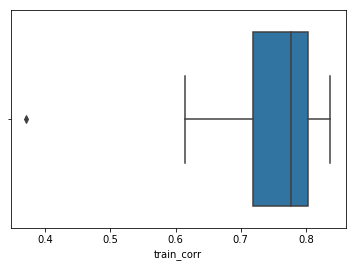

In [72]:
sns.boxplot("train_corr", data=full_df)

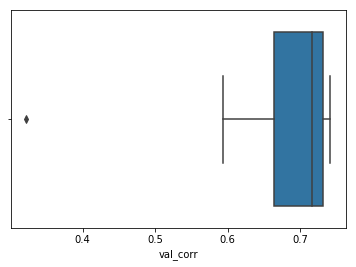

In [73]:
sns.boxplot("val_corr", data=full_df)

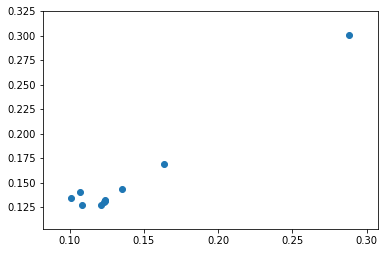

In [75]:
plt.scatter(full_df["train_rmse"], full_df["val_rmse"])

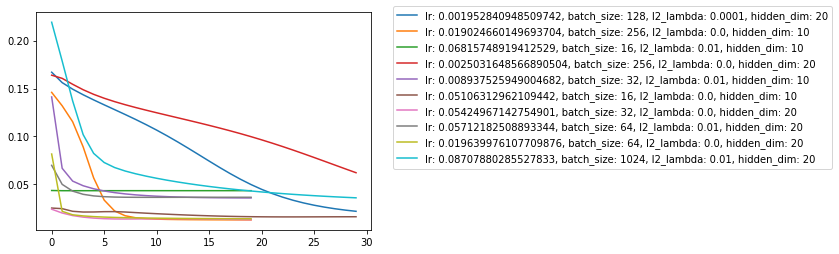

In [47]:
metric = "loss"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    label = "lr: {}, batch_size: {}, l2_lambda: {}, hidden_dim: {}".format(
        trial.config["lr"], trial.config["batch_size"], trial.config["l2_lambda"], trial.config["hidden_dim"])
    plt.plot(df["training_iteration"], df[metric], label=label)

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

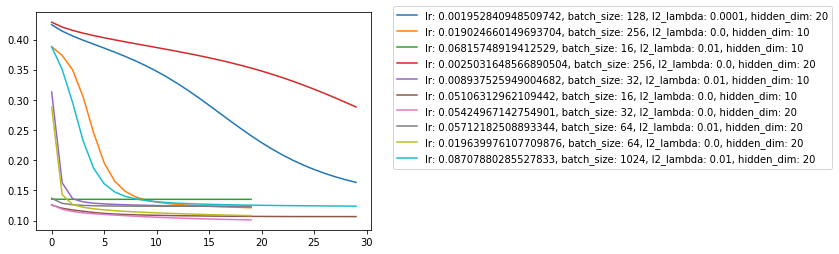

In [48]:
metric = "train_rmse"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    label = "lr: {}, batch_size: {}, l2_lambda: {}, hidden_dim: {}".format(
        trial.config["lr"], trial.config["batch_size"], trial.config["l2_lambda"], trial.config["hidden_dim"])
    plt.plot(df["training_iteration"], df[metric], label=label)

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

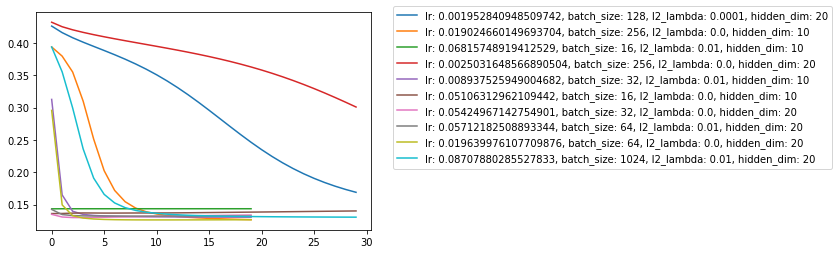

In [49]:
metric = "val_rmse"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    label = "lr: {}, batch_size: {}, l2_lambda: {}, hidden_dim: {}".format(
        trial.config["lr"], trial.config["batch_size"], trial.config["l2_lambda"], trial.config["hidden_dim"])
    plt.plot(df["training_iteration"], df[metric], label=label)

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

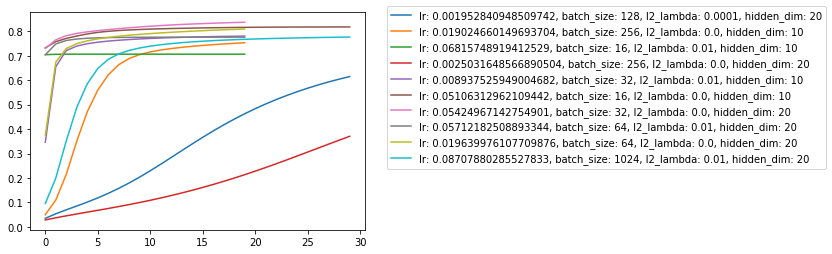

In [50]:
metric = "train_corr"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    label = "lr: {}, batch_size: {}, l2_lambda: {}, hidden_dim: {}".format(
        trial.config["lr"], trial.config["batch_size"], trial.config["l2_lambda"], trial.config["hidden_dim"])
    plt.plot(df["training_iteration"], df[metric], label=label)

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

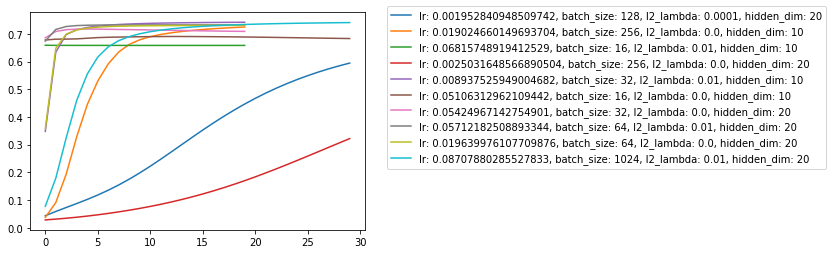

In [51]:
metric = "val_corr"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    label = "lr: {}, batch_size: {}, l2_lambda: {}, hidden_dim: {}".format(
        trial.config["lr"], trial.config["batch_size"], trial.config["l2_lambda"], trial.config["hidden_dim"])
    plt.plot(df["training_iteration"], df[metric], label=label)

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

In [91]:
performance_df["Drug Name"] = performance_df["Drug ID"].map(full_dataset.gdsc_drug_id_to_gdsc_name_mapper)
performance_df.head()

Drug ID  Model RMSE  Model correlation  Dummy RMSE  Dummy correlation  \
0       94    0.156892           0.032714    0.154868                NaN   
1     1164    0.050059           0.273856    0.048764                NaN   
2     1558    0.077407           0.364255    0.079684                NaN   
3      329    0.074654           0.482711    0.075493                NaN   
4       35    0.101331           0.244736    0.090690                NaN   

   No. samples   Drug Name  
0           41      TGX221  
1           52     XMD8-92  
2           81   Lapatinib  
3           92    QL-XI-92  
4           41  NVP-TAE684

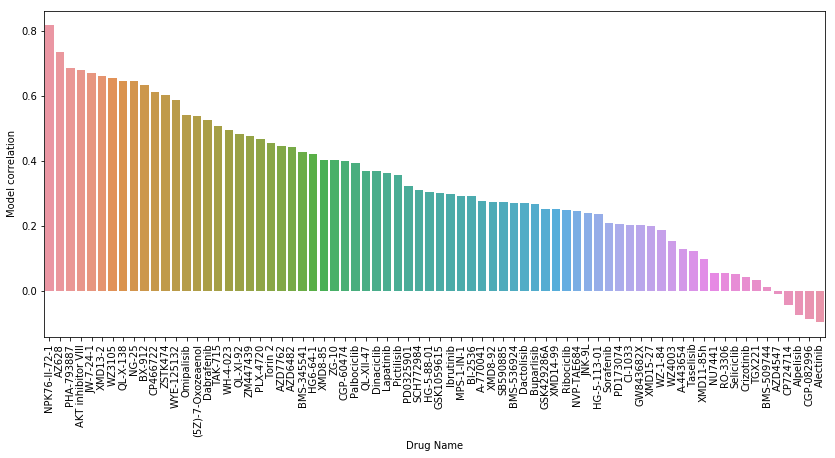

In [94]:
plt.figure(figsize=(14, 6))
sns.barplot(x="Drug Name", y="Model correlation", data=performance_df, 
            order=performance_df.sort_values("Model correlation", ascending=False)["Drug Name"])
plt.xticks(rotation=90)
plt.show()

In [85]:
samples_train[samples_train.DRUG_ID == 1560].shape

(601, 3)

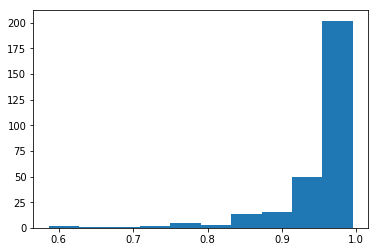

In [88]:
plt.hist(samples_train[samples_train.DRUG_ID == 94]["AUC"])
plt.show()

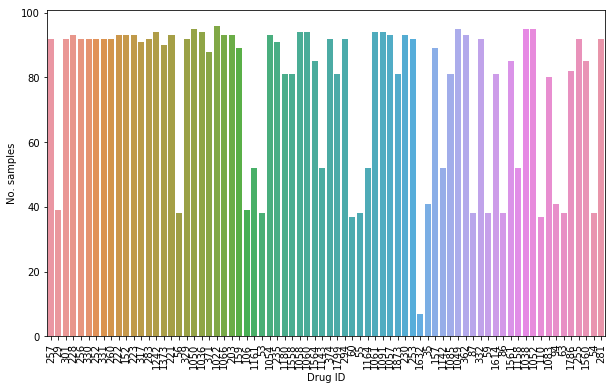

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Drug ID", y="No. samples", data=performance_df, 
            order=performance_df.sort_values("Model correlation", ascending=False)["Drug ID"])
plt.xticks(rotation=90)
plt.show()

In [90]:
full_dataset.gdsc_drug_id_to_gdsc_name_mapper[29]

'AZ628'

In [77]:
full_dataset.gdsc_id_to_kinomescan_name_mapper[281]

'CH5424802'

In [80]:
drug_data_df.loc[281]

Protein
MAPKAPK2       0.027450
MARK1          0.289362
CAMKK2        -1.568847
MARK2          0.663306
TGFBR1         0.496730
ERK5           0.457065
EPHA7          0.525718
MK01           0.504703
RAF1           0.514330
TNNI3K         0.640979
ERK8           0.825678
DDR1           0.592736
NLK            0.605929
EPHB3          0.063682
PGFRB         -0.350653
AURKA          0.640537
CSNK1G3        0.375350
DMPK2          0.646900
CIT           -0.351069
ITK           -0.893782
RIOK3          0.858888
DAPK1         -1.837700
MARK3          0.562352
SNARK          0.511304
ERK4           0.247202
DAPK3         -1.883061
EPHB1         -1.159615
AXL           -1.447877
SRMS          -0.453266
NEK9           0.486758
                 ...   
PRKR           0.640455
FRK           -1.296302
MRCKA          0.491457
FLT3(D835H)   -1.107464
EPHA3          0.678183
KKCC1         -1.473084
M4K1          -1.185406
TTK           -0.705044
FLT3(ITD)     -1.376460
PIM3          -2.918102
EPHA5   

## Full development and evaluation loop in cells

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader


from sklearn import metrics

import ray
from ray import tune
from ray.tune import track

In [2]:
# Custom utilities imports
sys.path.append("../Modules")
from modeling import Dataset

In [3]:
class Model:
    def __init__(self, name, network):
        self.name = name
        self.network = network
        
    def train(self, train_samples, cell_line_features, drug_features,
             batch_size, optimizer, criterion, reg_lambda=0, log=True):
        """Perform training process by looping over training set in batches (one epoch) of the
        training."""
        no_batches = train_samples.shape[0] // batch_size + 1
        
        # Training the model
        self.network.train()
        for batch in range(no_batches):
            # Separate response variable batch
            if batch != no_batches:
                samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
            else:
                samples_batch = train_samples.iloc[batch * batch_size:]

            # Extract output variable batch
            y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)

            # Extract cell lines IDs for which data shall be extracted
            cl_ids = samples_batch["COSMIC_ID"].values
            # Extract corresponding cell line data
            cell_line_input_batch = cell_line_features.loc[cl_ids].values
            cell_line_input_batch = torch.from_numpy(cell_line_input_batch)

            # Extract drug IDs for which data shall be extracted
            drug_ids = samples_batch["DRUG_ID"].values
            # Extract corresponding drug data
            drug_input_batch = drug_features.loc[drug_ids].values
            drug_input_batch = torch.from_numpy(drug_input_batch)

            # Clear gradient buffers because we don't want to accummulate gradients 
            optimizer.zero_grad()

            # Perform forward pass
            batch_output = self.network(drug_input_batch.float(), cell_line_input_batch.float())

            reg_sum = 0
            for param in self.network.parameters():
                reg_sum += 0.5 * (param ** 2).sum()  # L2 norm

            # Compute the loss for this batch
            loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg_sum
            # Get the gradients w.r.t. the parameters
            loss.backward()
            # Update the parameters
            optimizer.step()
        return loss
    
    def predict(self, samples, cell_line_features, drug_features):
        """Predict response on a given set of samples"""
        y_true = samples["AUC"].values

        cl_input = cell_line_features.loc[samples["COSMIC_ID"].values].values
        drug_input = drug_features.loc[samples["DRUG_ID"].values].values

        self.network.eval()
        with torch.no_grad():
            predicted = self.network(torch.from_numpy(drug_input).float(), 
                             torch.from_numpy(cl_input).float())
        return predicted, y_true
    
    @staticmethod
    def per_drug_performance_df(samples, predicted, mean_training_auc=None):
        """Compute evaluation metrics per drug and return them in a DataFrame"""
        sample_with_predictions = samples.copy()
        sample_with_predictions["Predicted AUC"] = predicted.numpy()

        drugs = []
        model_corrs = []
        model_rmses = []
        dummy_corrs = []
        dummy_rmses = []
        no_samples = []

        for drug in sample_with_predictions.DRUG_ID.unique():
            df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
            if df.shape[0] < 2:
                continue
            if mean_training_auc:
                dummy_preds = [mean_training_auc] * df.shape[0]
            else:
                dummy_preds = [df["AUC"].mean()] * df.shape[0]
            dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
            dummy_corr = pearsonr(df["AUC"], dummy_preds)

            model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
            model_corr = pearsonr(df["AUC"], df["Predicted AUC"])

            drugs.append(drug)
            dummy_rmses.append(dummy_rmse)
            dummy_corrs.append(dummy_corr[0])

            model_rmses.append(model_rmse)
            model_corrs.append(model_corr[0])

            no_samples.append(df.COSMIC_ID.nunique())

        performance_per_drug = pd.DataFrame()
        performance_per_drug["Drug ID"] = drugs
        performance_per_drug["Model RMSE"] = model_rmses
        performance_per_drug["Model correlation"] = model_corrs

        performance_per_drug["Dummy RMSE"] = dummy_rmses
        performance_per_drug["Dummy correlation"] = dummy_corrs
        performance_per_drug["No. samples"] = no_samples

        return performance_per_drug
        
    @staticmethod
    def evaluate_predictions(y_true, preds):
        """Compute RMSE and correlation with true values for model predictions"""
        return metrics.mean_squared_error(y_true, preds) ** 0.5, pearsonr(y_true, preds)

In [4]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.sum(torch.mul(drug_outputs, cell_line_outputs), dim=1).view(-1, 1)
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs

## Load KINOMEscan preprocessed dataset with intersection of proteins screened for drugs

In [5]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


## Data preprocessing

#### Establish response data for samples (drug-cell line pairs)

In [6]:
response_df = full_dataset.response_data.copy()
print(response_df.shape, response_df.COSMIC_ID.nunique())
response_df.head(3)

(55936, 3) 987


DRUG_ID  COSMIC_ID       AUC
2748       29     683665  0.945160
2749       29     684055  0.926046
2750       29     684057  0.934873

#### Establish cell line features data

In [7]:
cell_line_data_df = full_dataset.full_cell_lines_data.copy()
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(922, 225)


cell_line_id  PRKX_exp  TIE1_exp  BMPR2_exp  PKMYT1_exp  \
cell_line_id                                                            
906826              906826  4.787607  3.056350   6.395463    5.550737   
687983              687983  5.001763  3.125097   6.634672    5.399054   
910927              910927  5.459631  2.989998   7.945827    5.541005   

              ABL2_exp  PLK1_exp  ACVR1_exp  MAP3K4_mut  SRPK1_exp  \
cell_line_id                                                         
906826        5.492917  3.853142   4.384087           0   7.410108   
687983        5.113815  4.218736   4.786061           0   7.776150   
910927        4.519127  3.694307   4.414635           0   7.079021   

                        ...             Tissue_lung_SCLC  Tissue_lymphoma  \
cell_line_id            ...                                                 
906826                  ...                            0                0   
687983                  ...                            1                0   
910927                  ...                            0                0   

              Tissue_myeloma  Tissue_nervous_system  Tissue_neuroblastoma  \
cell_line_id                                                                
906826                     0                      0                     0   
687983                     0                      0                     0   
910927                     0                      0                     0   

              Tissue_pancreas  Tissue_skin  Tissue_soft_tissue  \
cell_line_id                                                     
906826                      0            0                   0   
687983                      0            0                   0   
910927                      0            0                   0   

              Tissue_thyroid  Tissue_urogenital_system  
cell_line_id                                            
906826                     0                         0  
687983                     0                         0  
910927                     0                         0  

[3 rows x 225 columns]

In [8]:
# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
print(len(missing_cell_lines))

66


In [9]:
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_df.index = cell_line_data_df.cell_line_id
cell_line_data_df = cell_line_data_df.drop("cell_line_id", axis=1)

In [10]:
# Extract response only for cell lines for which features are present
print(response_df.shape)
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]
print(response_df.shape)

(55936, 3)
(52730, 3)


#### Establish drug features data

In [11]:
drug_data_df = full_dataset.drugs_data.copy()
print(drug_data_df.shape)
# Convert drug index from LINCS name to GDSC drug ID
drug_data_df.index = drug_data_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
drug_data_df.head(3)

(74, 294)


Protein         MAPKAPK2  MARK1  CAMKK2  MARK2  TGFBR1   ERK5  EPHA7   MK01  \
Small Molecule                                                                
1242               100.0   83.0    88.0   96.0    57.0  100.0   92.0   64.0   
86                 100.0  100.0     2.0   13.0   100.0  100.0  100.0  100.0   
29                 100.0  100.0    28.0   92.0   100.0  100.0   84.0  100.0   

Protein          RAF1  TNNI3K  ...     KGP1  ZAP70   ERK3    BLK  MYLK2  \
Small Molecule                 ...                                        
1242            100.0    77.0  ...     99.0   86.0   98.0   57.0   80.0   
86              100.0   100.0  ...      0.7  100.0  100.0  100.0  100.0   
29                2.3    15.0  ...    100.0  100.0  100.0    1.0  100.0   

Protein         KPCD3  FGFR3  ACVR1  GSK3A   KPCD  
Small Molecule                                     
1242             12.0   95.0    1.9  100.0  100.0  
86                1.6  100.0  100.0    1.0    0.9  
29               88.0  100.0  100.0  100.0   89.0  

[3 rows x 294 columns]

#### Experiment setup

In [26]:
# Specify network architecture
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]

torch_seed = np.random.randint(0, 100)
torch.manual_seed(torch_seed)

In [41]:
# Establish how many cells go to train/val/test sets
num_val_cell_lines = 100
num_test_cell_lines = 100

# Number of train/evaluation iterations
num_experimental_iterations = 3

# Number of parameter combinations to check in every iteration
num_tuning_samples = 2


# Data split seeds
split_seeds = np.random.randint(0, 100, size=num_experimental_iterations)

# Metric for parameter search
validation_metric = "val_rmse"
validation_mode = "min"

In [28]:
split_seeds

array([51, 40, 45])

In [29]:
# Establish directory for results storage
global_experiment_name = "Minimalistic KINOMEscan linear model wit SGD optimizer"
global_experiment_dir = "./Results/" + global_experiment_name

In [30]:
import os
if not os.path.exists(global_experiment_dir):
    os.makedirs(global_experiment_dir)

In [31]:
# Specify hyperparameter space to search on
search_space = {
    "lr": tune.loguniform(0.0001, 0.1),
    "batch_size": tune.choice([16, 32, 64, 128, 256, 512, 1024]),
    "l2_lambda": tune.choice([0.0, 0.001, 0.1, 10.]),
    "hidden_dim": tune.choice([10, 20]),
    "drug_bias": tune.choice(["True"]),
    "cell_line_bias": tune.choice(["True"]),
    "out_activation": tune.choice([torch.sigmoid]),
    "criterion": tune.choice([torch.nn.MSELoss()]),
    "epochs": tune.choice([3])
}

In [42]:
# Create and save JSON with experiment setup
setup = {"experiment name": global_experiment_name,
         "torch random seed": torch_seed,
         "dataset name": full_dataset.name,
         "dataset description": full_dataset.description,
         "drug features dimension": drug_dim,
         "cell lines features dimension": cell_line_dim,
         "num experimental iterations": num_experimental_iterations,
         "num val cell lines": num_val_cell_lines,
         "num test cell lines": num_test_cell_lines,
         "data_split_seeds": str(split_seeds),
         "optimizer": "SGD",
         "num tuning samples": num_tuning_samples,
         "validation metric": validation_metric
        }
import json
with open(global_experiment_dir + "/experiment description.json", "w") as f:
    json.dump(setup, f)

In [33]:
# Trainable function to pass into Tune 
def trainable_for_tuning(config):
    # Specify network
    network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, config["hidden_dim"],
                                                 drug_bias=config["drug_bias"],
                                                 cell_line_bias=config["cell_line_bias"],
                                                 out_activation_func=config["out_activation"])
    # Create Model instance
    model = Model("Model {}, lr: {}".format(experiment, config["lr"]), network)

    # Specify loss function
    criterion = config["criterion"]
    # Specify optimizer
    optimizer = torch.optim.SGD(model.network.parameters(), lr=config["lr"])

    for epoch in range(1, config["epochs"] + 1):
        # Iterate over traning set
        loss = model.train(samples_train, cell_line_data_df, drug_data_df, config["batch_size"],
                     optimizer, criterion, reg_lambda=config["l2_lambda"])
        # Evaluate on training data
        predicted, y_true = model.predict(samples_train, cell_line_data_df, drug_data_df)
        train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_train, predicted)
        train_median_rmse = performance_df["Model RMSE"].median()
        train_median_corr = performance_df["Model correlation"].median()
        if epoch == config["epochs"]:
            performance_df.to_csv("./performance_per_drug_train.csv", index=False)

        # Evaluate on validation data
        predicted, y_true = model.predict(samples_val, cell_line_data_df, drug_data_df)
        val_rmse, val_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_val, predicted)
        val_median_rmse = performance_df["Model RMSE"].median()
        val_median_corr = performance_df["Model correlation"].median()
        if epoch == config["epochs"]:
            performance_df.to_csv("./performance_per_drug_val.csv", index=False)

        track.log(loss = loss.item(),
                  train_rmse=train_rmse, 
                  train_corr=train_corr[0], 
                  train_median_rmse = train_median_rmse, 
                  train_median_corr=train_median_corr,
                  val_rmse=val_rmse, 
                  val_corr=val_corr[0], 
                  val_median_rmse = val_median_rmse, 
                  val_median_corr=val_median_corr)

#### Hyperparameter tuning and evaluation iterations

In [39]:
for experiment in range(1, num_experimental_iterations + 1):
    # Data preprocessing
    # Split data into train/val/test sets
    samples_train, samples_val, samples_test, cell_lines_test, cell_lines_val = Dataset.samples_train_test_split(
                                                                            response_df,
                                                                            num_val_cell_lines,
                                                                            num_test_cell_lines,
                                                                            split_seeds[experiment - 1],
                                                                            shuffle=True)
    # Normalize the data
    # Cell line data
    cols_subset = [col for col in list(cell_line_data_df) if col.endswith("_exp")]
    rows_subset = [x for x in cell_line_data_df.index if x not in cell_lines_test + cell_lines_val]

    cell_line_data_df = Dataset.standardize_data(cell_line_data_df, cols_subset=cols_subset,
                                                rows_subset=rows_subset)
    # Drug data
    drug_data_df = Dataset.standardize_data(drug_data_df)
    
    # Resources to request by Tune
    ray.shutdown()
    ray.init(num_cpus=1, num_gpus=0)

    # Run the analysis
    experiment_name = "Experiment " + str(experiment)
    analysis = tune.run(trainable_for_tuning, 
                        name=experiment_name,
                        config=search_space, num_samples=num_tuning_samples, 
                        local_dir=global_experiment_dir,
                        verbose=1)
    # Save summary dataframe for this analysis
    full_df = analysis.dataframe()
    full_df.to_csv(analysis._experiment_dir + "/" + "analysis_tuning_results.csv", index=False)
    
    # Merge training and validation samples
    samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
    
    # Extract best parameter combination for this tuning analysis
    best_config = analysis.get_best_config(metric=validation_metric, mode=validation_mode)
    
    # Save best config
    with open(analysis._experiment_dir + "/best_config.txt", "w") as f:
        for d in best_config:
            line = str(d) + ": " + str(analysis.get_best_config(metric="val_rmse", mode="min")[d]) + "\n"
            f.write(line)
    
    # Initialize best model
    # Specify best out activation
    if "sigmoid" in best_config["out_activation"]:
        out_activation = torch.sigmoid
    if best_config["out_activation"] == None:
        out_activation = None

    # Specify best loss function
    if best_config["criterion"] == "MSELoss()":
        criterion = torch.nn.MSELoss()

    network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, best_config["hidden_dim"],
                                             drug_bias=best_config["drug_bias"],
                                             cell_line_bias=best_config["cell_line_bias"],
                                             out_activation_func=out_activation)

    # Create Model instance
    best_model = Model(experiment_name + ": Best model", network)

    # Specify optimizer
    optimizer = torch.optim.SGD(best_model.network.parameters(), lr=best_config["lr"])

    results = {"epoch": [],
              "loss": [],
              "train_rmse": [], 
              "train_corr": [], 
              "train_median_rmse": [], 
              "train_median_corr": [],
              "test_rmse": [], 
              "test_corr": [], 
              "test_median_rmse": [], 
              "test_median_corr": []}


    for epoch in range(1, best_config["epochs"] + 1):
        # Iterate over traning set
        loss = best_model.train(samples_train_and_val, cell_line_data_df, drug_data_df, best_config["batch_size"],
                     optimizer, criterion, reg_lambda=best_config["l2_lambda"])
        # Evaluate on training data
        predicted, y_true = best_model.predict(samples_train_and_val, cell_line_data_df, drug_data_df)
        train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        train_performance_df = Model.per_drug_performance_df(samples_train_and_val, predicted)
        train_median_rmse = performance_df["Model RMSE"].median()
        train_median_corr = performance_df["Model correlation"].median()

        # Evaluate on test data
        predicted, y_true = best_model.predict(samples_test, cell_line_data_df, drug_data_df)
        test_rmse, test_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        train_performance_df = Model.per_drug_performance_df(samples_test, predicted)
        test_median_rmse = performance_df["Model RMSE"].median()
        test_median_corr = performance_df["Model correlation"].median()

        results["epoch"].append(epoch)
        results["loss"].append(loss.item())
        results["train_rmse"].append(train_rmse)
        results["train_corr"].append(train_corr[0])
        results["train_median_rmse"].append(train_median_rmse)
        results["train_median_corr"].append(train_median_corr)
        results["test_rmse"].append(test_rmse)
        results["test_corr"].append(test_corr[0])
        results["test_median_rmse"].append(test_median_rmse)
        results["test_median_corr"].append(test_median_corr)
        
    best_model_results = pd.DataFrame(results)
    best_model_results.to_csv(analysis._experiment_dir + "/best_model_test_results.csv", index=False)
    train_performance_df.to_csv(analysis._experiment_dir + "/best_model_per_drug_train_results.csv", index=False)
    test_performance_df.to_csv(analysis._experiment_dir + "/best_model_per_drug_test_results.csv", index=False)
    
    # Save trained best model
    with open(analysis._experiment_dir + "/best_trained_model.pkl", "wb") as f:
        dill.dump(best_model, f)
        
    print("*" * 50)
    print("Experiment", experiment)
    print(best_config)
    print("*" * 50)

(41305, 3) (5773, 3)
3.9016029999999997 4.462129


2019-12-16 17:31:17,228	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-16 17:31:17,231	INFO resource_spec.py:205 -- Starting Ray with 0.54 GiB memory available for workers and up to 0.28 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


(47078, 3)
3.9016029999999997 4.462129
(41130, 3) (5840, 3)
4.154058 3.7428500000000002


2019-12-16 17:31:18,103	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-16 17:31:18,107	INFO resource_spec.py:205 -- Starting Ray with 0.54 GiB memory available for workers and up to 0.28 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


(46970, 3)
4.154058 3.7428500000000002
(41592, 3) (5607, 3)
3.532313 3.5086139999999997


2019-12-16 17:31:18,899	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-16 17:31:18,902	INFO resource_spec.py:205 -- Starting Ray with 0.54 GiB memory available for workers and up to 0.28 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


(47199, 3)
3.532313 3.5086139999999997


In [57]:
analysis._experiment_dir

'/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Model development/Results/Minimalistic KINOMEscan linear model wit SGD optimizer/Experiment 3'

In [35]:
full_df = analysis.dataframe()
#full_df.to_csv(analysis._experiment_dir + "/" + "analysis_tuning_train_results.csv", index=False)

In [37]:
full_df.head()

config/batch_size config/cell_line_bias config/criterion config/drug_bias  \
0                512                  True        MSELoss()             True   
1               1024                  True        MSELoss()             True   

   config/epochs  config/hidden_dim  config/l2_lambda  config/lr  \
0              3                 20               0.1   0.062255   
1              3                 10               0.1   0.003261   

                               config/out_activation                 date  \
0  <built-in method sigmoid of type object at 0x7...  2019-12-16_17-26-24   
1  <built-in method sigmoid of type object at 0x7...  2019-12-16_17-26-29   

     ...     train_corr  train_median_corr train_median_rmse train_rmse  \
0    ...       0.464495           0.179203          0.337535   0.331702   
1    ...       0.005366           0.015674          0.410380   0.405396   

   training_iteration  trial_id  val_corr val_median_corr  val_median_rmse  \
0                   2  ca42941e  0.445353        0.197276         0.338969   
1                   2  ca4b118e  0.008811       -0.018934         0.413743   

   val_rmse  
0  0.333225  
1  0.407248  

[2 rows x 35 columns]

In [44]:
best_config = analysis.get_best_config(metric=validation_metric, mode=validation_mode)
best_config

{'batch_size': 512,
 'cell_line_bias': 'True',
 'criterion': 'MSELoss()',
 'drug_bias': 'True',
 'epochs': 3,
 'hidden_dim': 20,
 'l2_lambda': 0.1,
 'lr': 0.0622552350663846,
 'out_activation': '<built-in method sigmoid of type object at 0x7f57c9750fc0>'}

In [32]:
print(samples_train.shape, samples_val.shape)
samples_val.tail()

(41302, 3) (5739, 3)


DRUG_ID  COSMIC_ID       AUC
219213     1057    1298356  0.837679
51030      1564    1290797  0.866940
215768     1052     713899  0.988156
215683     1050    1503371  0.881432
100595      283     713899  0.847990

In [33]:
# Merge train and validation set
samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
print(samples_train_and_val.shape)
samples_train_and_val.tail()

(47041, 3)


DRUG_ID  COSMIC_ID       AUC
219213     1057    1298356  0.837679
51030      1564    1290797  0.866940
215768     1052     713899  0.988156
215683     1050    1503371  0.881432
100595      283     713899  0.847990

In [34]:
# Initialize best model
# Specify best out activation
if "sigmoid" in best_config["out_activation"]:
    out_activation = torch.sigmoid
if best_config["out_activation"] == "None":
    out_activation = None
    
# Specify best loss function
if best_config["criterion"] == "MSELoss()":
    criterion = torch.nn.MSELoss()
    
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, best_config["hidden_dim"],
                                         drug_bias=best_config["drug_bias"],
                                         cell_line_bias=best_config["cell_line_bias"],
                                         out_activation_func=out_activation)

# Create Model instance
best_model = Model(experiment_name + ": Best model", network)

# Specify optimizer
optimizer = torch.optim.SGD(best_model.network.parameters(), lr=best_config["lr"])

results = {"epoch": [],
          "loss": [],
          "train_rmse": [], 
          "train_corr": [], 
          "train_median_rmse": [], 
          "train_median_corr": [],
          "test_rmse": [], 
          "test_corr": [], 
          "test_median_rmse": [], 
          "test_median_corr": []}


for epoch in range(1, best_config["epochs"] + 1):
    # Iterate over traning set
    loss = best_model.train(samples_train_and_val, cell_line_data_df, drug_data_df, best_config["batch_size"],
                 optimizer, criterion, reg_lambda=best_config["l2_lambda"])
    # Evaluate on training data
    predicted, y_true = best_model.predict(samples_train_and_val, cell_line_data_df, drug_data_df)
    train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
    performance_df = Model.per_drug_performance_df(samples_train_and_val, predicted)
    train_median_rmse = performance_df["Model RMSE"].median()
    train_median_corr = performance_df["Model correlation"].median()
    
    # Evaluate on test data
    predicted, y_true = best_model.predict(samples_test, cell_line_data_df, drug_data_df)
    test_rmse, test_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
    performance_df = Model.per_drug_performance_df(samples_test, predicted)
    test_median_rmse = performance_df["Model RMSE"].median()
    test_median_corr = performance_df["Model correlation"].median()
    
    results["epoch"].append(epoch)
    results["loss"].append(loss.item())
    results["train_rmse"].append(train_rmse)
    results["train_corr"].append(train_corr[0])
    results["train_median_rmse"].append(train_median_rmse)
    results["train_median_corr"].append(train_median_corr)
    results["test_rmse"].append(test_rmse)
    results["test_corr"].append(test_corr[0])
    results["test_median_rmse"].append(test_median_rmse)
    results["test_median_corr"].append(test_median_corr)
    
    best_model_results = pd.DataFrame(results)
    best_model_results.to_csv()

/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0.17532868683338165
0.004188628867268562
0.0014079331886023283
0.0005961424903944135
0.00032393800211139023
0.00021770682360511273
0.00017347726679872721
0.00015498418360948563
0.0001470159913878888
0.00014203466707840562
0.00013616927026305348
0.00012789950415026397
0.00011715821892721578
0.00010461641795700416
9.11747119971551e-05
7.769775402266532e-05
6.487008795375004e-05
5.3136362112127244e-05
4.274120510672219e-05
3.3742508094292134e-05


In [46]:
None == None

True

In [64]:
for d in analysis.get_best_config(metric="val_rmse", mode="min"):
    print(d, analysis.get_best_config(metric="val_rmse", mode="min")[d])

batch_size 512
cell_line_bias True
criterion MSELoss()
drug_bias True
epochs 3
hidden_dim 20
l2_lambda 0.1
lr 0.0622552350663846
out_activation <built-in method sigmoid of type object at 0x7f57c9750fc0>


In [67]:
with open("text.txt", "w") as f:
    for d in analysis.get_best_config(metric="val_rmse", mode="min"):
        line = str(d) + ": " + str(analysis.get_best_config(metric="val_rmse", mode="min")[d]) + "\n"
        f.write(line)